# Div Arb Black Scholes

**Use the Black Scholes Pricing Model to purchase underlying and Puts that seem to be underpriced** (we can also look to just purchasing Puts that are underpriced.
    
This looks is a little more nuanced than Vanilla Straight Up Arb. We want to see if Greek Delta is accurate for put options during stock movement after Ex-Dividend Date. If delta is 0 this approach will not work. We calculate our new delta d' that is more accurate by taking into account dividend dates.    
    
Now our goal is to find when 1+d' is "close" to 0, Dividend is "high", and Underlying Volatility is "low"    
Our profit percentage would be Dividend*(1-tax)/(Underlying + Put_price)

In [1]:
%%capture

!pip3 install gcsfs

In [94]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
from bisect import bisect_left
import matplotlib.pyplot as plt
import scipy.stats

In [5]:
pd.set_option('display.max_columns', 500)
PATH_TO_DIV = "gs://ucf-data/dividends/"
PATH_TO_OPT = "gs://ucf-data/Options/"
PATH_TO_DAILY = "gs://ucf-data/daily_stocks.csv"

In [6]:
stonks = pd.read_csv(PATH_TO_DAILY)    #pd.read_csv('prupes_stonks.csv')

/usr/local/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
def get_dividend_df(ticker):
    df = pd.read_csv('{}{}.csv'.format(PATH_TO_DIV,ticker.upper()))
    df['DATE'] = df.apply (lambda row: datetime.strptime(row['exOrEffDate'],"%m/%d/%Y"), axis=1)
    return df
def get_opt_df(ticker):
    opts = pd.read_csv('{}{}.csv'.format(PATH_TO_OPT,ticker.upper()))
    opts['date'] = opts['date'].apply(str)
    opts['DATE'] = opts.apply (lambda row: datetime.strptime(row['date'],"%Y%m%d"), axis=1)
    return opts
def get_daily_df(ticker):
    daily = pd.read_csv('{}{}/{}_day_close_.csv'.format(PATH_TO_DAILY, ticker.upper(), ticker.upper()))
    daily['DATE'] = daily.apply(lambda row: datetime.strptime(row['timestamp'],"%Y-%m-%d"), axis=1)
    return daily
def get_stonks_df(ticker):
    stocks = stonks[stonks['TICKER'] == ticker]
    stocks['date'] = stocks['date'].apply(str)
    stocks['DATE'] = stocks.apply (lambda row: datetime.strptime(row['date'],"%Y%m%d"), axis=1)
    return stocks
def convert_date(s):
    a = datetime.strptime(s,"%d/%m/%Y")
    return a.strftime("%Y%m%d")
def previous_day(dates, current_day):
    prev = current_day - timedelta(days=1)
    #print(prev)
    insertion_point = bisect_left(dates, current_day)-1
    if insertion_point == -1:
        return False
    else:
        return dates[insertion_point]
def next_day(dates, current_day):
    nex = current_day + timedelta(days=1)
    #print(prev)
    insertion_point = bisect_left(dates, nex)
    if insertion_point == len(dates):
        return False
    else:
        return dates[insertion_point]
def gen_dates(df):
    return sorted(datetime.strptime(str(elt), "%Y%m%d") for elt in list(df.date_x) if isinstance(datetime.strptime(str(elt), "%Y%m%d"), dt.date))

In [9]:
get_stonks_df("AAPL").head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX,DATE
1530307,14593,20070103,AAPL,81.90,86.58,83.80,83.76,83.79,86.29,-0.012258,2007-01-03
1530308,14593,20070104,AAPL,83.82,85.95,85.66,85.62,85.64,84.05,0.022196,2007-01-04
1530309,14593,20070105,AAPL,84.40,86.20,85.05,85.15,85.15,85.77,-0.007121,2007-01-05
1530310,14593,20070108,AAPL,85.28,86.53,85.47,85.46,85.46,85.96,0.004938,2007-01-08
1530311,14593,20070109,AAPL,85.15,92.98,92.57,92.53,92.55,86.45,0.083070,2007-01-09


In [10]:
get_opt_df("AAPL").head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,DATE
0,101594,20150630,AAPL 150702C100000,1,20150702,20150630.0,C,100000,25.55,25.65,15,6,1.657665,0.971807,0.004203,0.601158,-90.97760,108201233,1,0,100,0,125.42603,w,NaN,NaN,3783310,AAPL,3571,0,4,NaN,0,314,APPLE INC,NaN,A,0,2015-06-30
1,101594,20150630,AAPL 150702C105000,1,20150702,20150630.0,C,105000,20.55,20.65,16,7,1.352380,0.966076,0.006003,0.699296,-86.50655,108201234,1,0,100,0,125.42603,w,NaN,NaN,3783310,AAPL,3571,0,4,NaN,0,314,APPLE INC,NaN,A,0,2015-06-30
2,101594,20150630,AAPL 150702C107000,1,20150702,20150630.0,C,107000,18.25,18.80,10,0,1.115425,0.975360,0.005581,0.536270,-54.77605,108249631,1,0,100,0,125.42603,w,NaN,NaN,3783310,AAPL,3571,0,4,NaN,0,314,APPLE INC,NaN,A,0,2015-06-30
3,101594,20150630,AAPL 150702C108000,1,20150702,NaN,C,108000,17.05,17.80,0,0,NaN,NaN,NaN,NaN,NaN,108249632,1,0,100,0,125.42603,w,NaN,NaN,3783310,AAPL,3571,0,4,NaN,0,314,APPLE INC,NaN,A,0,2015-06-30
4,101594,20150630,AAPL 150702C109000,1,20150702,20150630.0,C,109000,16.55,16.65,286,366,1.112591,0.959576,0.008420,0.807882,-82.13522,108051023,1,0,100,0,125.42603,w,NaN,NaN,3783310,AAPL,3571,0,4,NaN,0,314,APPLE INC,NaN,A,0,2015-06-30


In [11]:
get_dividend_df("AAPL").head()

,exOrEffDate,type,amount,declarationDate,recordDate,paymentDate,Unnamed: 6,DATE
0,11/07/2019,Cash,$0.77,10/30/2019,11/11/2019,11/14/2019,NaN,2019-11-07
1,08/09/2019,Cash,$0.77,07/30/2019,08/12/2019,08/15/2019,NaN,2019-08-09
2,05/10/2019,Cash,$0.77,04/30/2019,05/13/2019,05/16/2019,NaN,2019-05-10
3,02/08/2019,Cash,$0.73,01/29/2019,02/11/2019,02/14/2019,NaN,2019-02-08
4,11/08/2018,Cash,$0.73,11/01/2018,11/12/2018,11/15/2018,NaN,2018-11-08


## Step 1: Merge 3 Tables Together (Code)

In [12]:
def merge(ticker):
    dividends = get_dividend_df(ticker)
    opts = get_opt_df(ticker)
    daily = get_stonks_df(ticker)#get_daily_df(ticker)
    temp = pd.merge(dividends, daily, on='DATE', how='outer')
    last = pd.merge(opts, temp, on='DATE')
    return last

In [13]:
def merge_before(ticker, days):
    dividends = get_dividend_df(ticker)
    dividends['DATE'] = dividends.apply (lambda row: row['DATE'] - timedelta(days=days), axis=1)
    opts = get_opt_df(ticker)
    daily = get_stonks_df(ticker)#get_daily_df(ticker)
    
    
    temp = pd.merge(dividends, daily, on='DATE', how='outer')
    last = pd.merge(opts, temp, on='DATE')
    return last

In [15]:
ibm_consolidated = merge_before("IBM", 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
ibm_consolidated.head()

,secid,date_x,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,DATE,exOrEffDate,type,amount,declarationDate,recordDate,paymentDate,Unnamed: 6,PERMNO,date_y,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX
0,106276,20150630,IBM 150702C105000,1,20150702,20150630.0,C,105000,55.90,59.3,2,3,NaN,NaN,NaN,NaN,NaN,108215164,1,0,100,0,162.661335,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12490.0,20150630,IBM,162.12,164.0,162.66,162.66,162.67999,163.99001,-0.001902
1,106276,20150630,IBM 150702C110000,1,20150702,NaN,C,110000,50.85,54.9,0,0,2.628677,0.982495,0.001367,0.520414,-125.1663,108215165,1,0,100,0,162.661335,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12490.0,20150630,IBM,162.12,164.0,162.66,162.66,162.67999,163.99001,-0.001902
2,106276,20150630,IBM 150702C115000,1,20150702,NaN,C,115000,45.90,50.0,0,0,2.486416,0.975950,0.001892,0.682644,-154.8934,108215166,1,0,100,0,162.661335,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12490.0,20150630,IBM,162.12,164.0,162.66,162.66,162.67999,163.99001,-0.001902
3,106276,20150630,IBM 150702C120000,1,20150702,NaN,C,120000,41.00,45.0,0,0,2.286495,0.970093,0.002467,0.817618,-170.8167,108215167,1,0,100,0,162.661335,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12490.0,20150630,IBM,162.12,164.0,162.66,162.66,162.67999,163.99001,-0.001902
4,106276,20150630,IBM 150702C125000,1,20150702,NaN,C,125000,36.00,40.0,0,0,2.024913,0.966544,0.003056,0.896650,-165.9657,108215168,1,0,100,0,162.661335,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12490.0,20150630,IBM,162.12,164.0,162.66,162.66,162.67999,163.99001,-0.001902


In [80]:
#filter out by volume and exOrEffDate and want delta
filtered = ibm_consolidated[ibm_consolidated['volume'] > 0]
filtered = filtered[filtered.exOrEffDate.notnull()]
filtered = filtered[filtered.delta.notnull()]
filtered = filtered[filtered.cp_flag == 'P']

In [81]:
filtered[filtered.DATE == np.datetime64(datetime(2015, 8, 5, 0, 0))]

,secid,date_x,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,DATE,exOrEffDate,type,amount,declarationDate,recordDate,paymentDate,Unnamed: 6,PERMNO,date_y,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX
18395,106276,20150805,IBM 150807P145000,1,20150807,20150805.0,P,145000,0.00,0.13,10,47,0.543893,-0.026435,0.009630,0.715480,-35.505460,108215227,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18399,106276,20150805,IBM 150807P149000,1,20150807,20150805.0,P,149000,0.00,0.12,1,29,0.373131,-0.034434,0.017469,0.890286,-30.310740,108215231,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18400,106276,20150805,IBM 150807P150000,1,20150807,20150805.0,P,150000,0.00,0.04,85,768,0.276398,-0.017039,0.013074,0.494179,-12.446760,108215232,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18401,106276,20150805,IBM 150807P152500,1,20150807,20150805.0,P,152500,0.04,0.07,67,2556,0.220386,-0.050611,0.040381,1.215042,-24.437610,108215233,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18402,106276,20150805,IBM 150807P155000,1,20150807,20150805.0,P,155000,0.27,0.30,937,1504,0.186550,-0.224510,0.136874,2.710233,-59.326590,108215234,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19022,106276,20150805,IBM 160115P165000,1,20160115,20150805.0,P,165000,12.80,13.00,8,8100,0.191653,-0.625923,0.018672,39.449260,-8.063214,101633603,1,0,100,0,156.904878,NaN,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
19024,106276,20150805,IBM 160115P175000,1,20160115,20150805.0,P,175000,20.00,21.20,7,1982,0.196806,-0.774840,0.014416,30.841510,-6.338104,101633605,1,0,100,0,156.904878,NaN,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
19025,106276,20150805,IBM 160115P180000,1,20160115,20150805.0,P,180000,23.75,25.65,7,3609,0.191975,-0.840704,0.012004,24.515780,-4.829496,101633606,1,0,100,0,156.904878,NaN,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
19029,106276,20150805,IBM 160115P200000,1,20160115,20150805.0,P,200000,42.70,46.00

In [68]:
filtered.head()

,secid,date_x,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,DATE,exOrEffDate,type,amount,declarationDate,recordDate,paymentDate,Unnamed: 6,PERMNO,date_y,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX
18355,106276,20150805,IBM 150807C157500,1,20150807,20150805.0,C,157500,0.49,0.52,1149,1540,0.077606,0.734243,0.509664,2.998960,-38.440350,108215198,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18356,106276,20150805,IBM 150807C160000,1,20150807,20150805.0,C,160000,0.07,0.09,990,2611,0.184641,0.097359,0.102357,1.860467,-43.524960,108215199,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18357,106276,20150805,IBM 150807C162500,1,20150807,20150805.0,C,162500,0.02,0.04,307,2179,0.253231,0.028452,0.024533,0.713357,-19.618660,108215200,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18358,106276,20150805,IBM 150807C165000,1,20150807,20150805.0,C,165000,0.00,0.01,406,1568,0.272447,0.005102,0.004796,0.168237,-4.439182,108215201,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903
18359,106276,20150805,IBM 150807C167500,1,20150807,20150805.0,C,167500,0.00,0.01,446,1392,0.341888,0.004089,0.003067,0.140973,-4.469678,108215202,1,0,100,0,156.601286,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-05,08/06/2015,Cash,$1.30,07/28/2015,08/10/2015,09/10/2015,NaN,12490.0,20150805,IBM,157.48,159.53999,157.89999,157.84,157.87,159.10001,0.001903


In [50]:
dates = gen_dates(ibm_consolidated)

In [51]:
next_day(dates, datetime(2015, 6, 30, 0, 0))

datetime.datetime(2015, 7, 1, 0, 0)

In [112]:
opt_changes = []
naive_changes = []
div_changes = []

for index, row in filtered.iterrows():
    try:
        symbol = row['symbol']
        div = float(row['amount'][1:])
        day = next_day(dates, datetime.strptime(row['date_x'], '%Y%m%d'))
        a = ibm_consolidated[(ibm_consolidated.DATE == np.datetime64(day)) & (ibm_consolidated.symbol == symbol)]
        next_row = a.iloc[0]
        price_change = next_row['PRC']-row['PRC']
        opt_change = next_row['best_offer']-row['best_offer']
        delta = row['delta']
        naive_pricing = delta*price_change
        div_pricing = delta*(price_change+div)
        
        #print(np.isnan(opt_change),np.isnan(naive_pricing),np.isnan(div_pricing))

        if not np.isnan(opt_change) and not  np.isnan(naive_pricing) and not np.isnan(div_pricing):
            print(price_change, opt_change, row['delta'], naive_pricing, div_pricing)
            opt_changes.append(opt_change)
            naive_changes.append(naive_pricing)
            div_changes.append(div_pricing)
    except:
        pass
    #print(row)
    #break

-1.5799800000000062 0.37 -0.026435000000000004 0.04176677130000017 0.007401271300000163
-1.5799800000000062 0.010000000000000009 -0.034434 0.05440503132000021 0.009640831320000211
-1.5799800000000062 0.0 -0.017039 0.026921279220000104 0.004770579220000104
-1.5799800000000062 -0.020000000000000004 -0.050611 0.07996436778000032 0.01417006778000031
-1.5799800000000062 -0.09 -0.22451 0.3547213098000014 0.06285830980000137
-1.5799800000000062 0.010000000000000009 -0.659362 1.041778772760004 0.18460817276000402
-1.5799800000000062 0.3999999999999999 -0.93555 1.4781502890000058 0.26193528900000573
-1.5799800000000062 0.35000000000000053 -0.953095 1.505871038100006 0.26684753810000583
-1.5799800000000062 0.34999999999999964 -0.9615229999999999 1.5191871095400058 0.2692072095400059
-1.5799800000000062 0.34999999999999964 -0.990999 1.565758600020006 0.27745990002000603
-1.5799800000000062 0.34999999999999964 -0.978835 1.546539723300006 0.274054223300006
-1.5799800000000062 0.09000000000000002 -0

-1.6399999999999864 0.0 -0.23013699999999998 0.37742467999999685 0.07824657999999685
-1.6399999999999864 0.0 -0.292261 0.479308039999996 0.099368739999996
-1.6399999999999864 0.020000000000000018 -0.363091 0.595469239999995 0.12345093999999503
-1.6399999999999864 0.06000000000000005 -0.440162 0.721865679999994 0.14965507999999397
-1.6399999999999864 0.10999999999999988 -0.521289 0.8549139599999929 0.17723825999999288
-1.6399999999999864 0.16000000000000014 -0.603306 0.9894218399999918 0.20512403999999174
-1.6399999999999864 0.3500000000000001 -0.681894 1.1183061599999906 0.23184395999999066
-1.6399999999999864 0.4500000000000002 -0.7526109999999999 1.2342820399999896 0.25588773999998965
-1.6399999999999864 0.34999999999999964 -0.8122060000000001 1.3320178399999891 0.27615003999998894
-1.6399999999999864 0.25 -0.8501190000000001 1.3941951599999884 0.2890404599999884
-1.6399999999999864 0.39999999999999947 -0.8995209999999999 1.4752144399999876 0.30583713999998763
-1.6399999999999864 0.0

0.81998999999999 -0.06 -0.041441000000000006 -0.03398120558999959 -0.09199860558999959
0.81998999999999 -0.1 -0.061576 -0.05049170423999939 -0.13669810423999937
0.81998999999999 -0.13 -0.075475 -0.061888745249999245 -0.16755374524999925
0.81998999999999 -0.16 -0.091162 -0.0747519283799991 -0.2023787283799991
0.81998999999999 -0.21 -0.11389 -0.09338866109999887 -0.25283466109999886
0.81998999999999 -0.26 -0.139256 -0.1141885274399986 -0.30914692743999855
0.81998999999999 -0.33 -0.168402 -0.13808795597999832 -0.3738507559799983
0.81998999999999 -0.43999999999999995 -0.20591900000000002 -0.16885152080999796 -0.45713812080999794
0.81998999999999 -0.52 -0.250596 -0.20548621403999748 -0.5563206140399974
0.81998999999999 -0.63 -0.29909600000000003 -0.24525572903999704 -0.6639901290399971
0.81998999999999 -0.7700000000000001 -0.354846 -0.29097017153999644 -0.7877545715399964
0.81998999999999 -0.9099999999999999 -0.41682600000000003 -0.34179315173999586 -0.9253495517399959
0.81998999999999 -1.0

-0.5500000000000114 -0.06 -0.112755 0.06201525000000128 -0.0958417499999987
-0.5500000000000114 -0.10000000000000003 -0.146884 0.08078620000000167 -0.12485139999999831
-0.5500000000000114 -0.16999999999999998 -0.18568099999999998 0.1021245500000021 -0.15782884999999786
-0.5500000000000114 -0.3799999999999999 -0.33799 0.18589450000000385 -0.28729149999999615
-0.5500000000000114 -0.56 -0.551239 0.3031814500000063 -0.4685531499999937
-0.5500000000000114 -0.6999999999999997 -0.820219 0.45112045000000933 -0.6971861499999906
-0.5500000000000114 0.0 -0.011731 0.0064520500000001335 -0.009971349999999865
-0.5500000000000114 0.05 -0.018471 0.010159050000000211 -0.01570034999999979
-0.5500000000000114 -0.04000000000000001 -0.040498 0.02227390000000046 -0.03442329999999953
-0.5500000000000114 -0.009999999999999981 -0.043545 0.023949750000000495 -0.0370132499999995
-0.5500000000000114 -0.04000000000000001 -0.051507000000000004 0.02832885000000059 -0.043780949999999416
-0.5500000000000114 -0.0600000

-0.5500000000000114 -1.0999999999999979 -0.8605139999999999 0.4732827000000097 -0.7314368999999901
-0.5500000000000114 -0.5500000000000007 -0.9761639999999999 0.5368902000000111 -0.8297393999999888
-0.5500000000000114 -0.010000000000000002 -0.0019260000000000002 0.001059300000000022 -0.0016370999999999782
-0.5500000000000114 0.0 -0.004483 0.002465650000000051 -0.0038105499999999486
-0.5500000000000114 0.010000000000000009 -0.064088 0.035248400000000735 -0.05447479999999927
-0.5500000000000114 -0.07999999999999985 -0.084715 0.04659325000000096 -0.07200774999999902
-0.5500000000000114 -0.020000000000000018 -0.109527 0.06023985000000125 -0.09309794999999875
-0.5500000000000114 -0.11999999999999966 -0.142795 0.07853725000000163 -0.12137574999999837
-0.5500000000000114 -0.08999999999999986 -0.18513800000000002 0.10182590000000212 -0.1573672999999979
-0.5500000000000114 -0.10000000000000009 -0.23806300000000002 0.13093465000000273 -0.2023535499999973
-0.5500000000000114 -0.15000000000000036 

-2.2900100000000236 0.13000000000000034 -0.388391 0.8894192739100092 0.3456718739100092
-2.2900100000000236 0.35000000000000053 -0.615751 1.4100759475100146 0.5480245475100146
-2.2900100000000236 -0.010000000000000009 -0.046979 0.10758237979000111 0.04181177979000111
-2.2900100000000236 -0.02999999999999997 -0.05977999999999999 0.13689679780000139 0.05320479780000141
-2.2900100000000236 0.0 -0.07576799999999999 0.17350947768000177 0.06743427768000179
-2.2900100000000236 0.020000000000000018 -0.098097 0.22464311097000234 0.08730731097000233
-2.2900100000000236 0.050000000000000044 -0.129741 0.29710818741000306 0.11547078741000308
-2.2900100000000236 0.06999999999999984 -0.172847 0.3958213584700041 0.1538355584700041
-2.2900100000000236 0.08000000000000007 -0.23121999999999998 0.5294961122000055 0.20578811220000548
-2.2900100000000236 0.13000000000000034 -0.30499699999999996 0.6984461799700071 0.2714503799700072
-2.2900100000000236 0.18000000000000016 -0.394988 0.9045264698800094 0.35154

-1.3599999999999852 -0.020000000000000018 -0.061792999999999994 0.08403847999999908 -0.008651020000000913
-1.3599999999999852 -0.01999999999999999 -0.081479 0.11081143999999879 -0.011407060000001204
-1.3599999999999852 -0.01999999999999999 -0.11120799999999999 0.15124287999999833 -0.015569120000001642
-1.3599999999999852 -0.030000000000000027 -0.15257 0.20749519999999777 -0.021359800000002257
-1.3599999999999852 -0.02999999999999997 -0.20834 0.28334239999999694 -0.02916760000000308
-1.3599999999999852 -0.050000000000000044 -0.283181 0.38512615999999583 -0.039645340000004185
-1.3599999999999852 -0.05999999999999994 -0.37805700000000003 0.5141575199999945 -0.05292798000000559
-1.3599999999999852 -0.08000000000000007 -0.488785 0.6647475999999928 -0.06842990000000723
-1.3599999999999852 -0.08999999999999986 -0.605432 0.823387519999991 -0.08476048000000895
-1.3599999999999852 -0.11999999999999966 -0.71424 0.9713663999999894 -0.09999360000001055
-1.3599999999999852 -0.1499999999999999 -0.806

-1.3599999999999852 -0.09999999999999964 -0.7952899999999999 1.0815943999999882 -0.11134060000001175
-1.3599999999999852 -0.05000000000000071 -0.878518 1.194784479999987 -0.12299252000001298
-1.3599999999999852 0.11999999999999966 -0.144571 0.19661655999999786 -0.02023994000000214
-1.3599999999999852 0.1499999999999999 -0.18753699999999998 0.2550503199999972 -0.026255180000002768
-1.3599999999999852 0.10000000000000053 -0.241326 0.32820335999999645 -0.033785640000003565
-1.3599999999999852 0.09999999999999964 -0.306395 0.41669719999999544 -0.04289530000000452
-1.3599999999999852 0.15000000000000036 -0.38156799999999996 0.5189324799999943 -0.05341952000000563
-1.3599999999999852 0.09999999999999964 -0.551762 0.7503963199999918 -0.07724668000000814
-1.3599999999999852 0.09999999999999964 -0.636519 0.8656658399999905 -0.0891126600000094
-1.3599999999999852 0.05000000000000071 -0.7143649999999999 0.9715363999999893 -0.10001110000001055
-1.3599999999999852 0.04999999999999716 -0.793804 1.07

-1.270009999999985 -0.04999999999999999 -0.035309 0.04484278308999947 -0.00812071691000053
-1.270009999999985 0.06 -0.052223 0.06632373222999921 -0.012010767770000784
-1.270009999999985 0.029999999999999916 -0.080032 0.1016414403199988 -0.018406559680001204
-1.270009999999985 0.040000000000000036 -0.125499 0.15938498498999812 -0.028863515010001884
-1.270009999999985 0.020000000000000018 -0.198795 0.252471637949997 -0.04572086205000298
-1.270009999999985 -0.06999999999999984 -0.31287800000000004 0.39735818877999535 -0.0719588112200047
-1.270009999999985 0.0 -0.46698 0.593069269799993 -0.10740073020000701
-1.270009999999985 -0.15000000000000036 -0.636192 0.8079702019199905 -0.14631779808000955
-1.270009999999985 -0.25 -0.7825310000000001 0.9938221953099884 -0.17997430469001177
-1.270009999999985 0.4499999999999993 -0.858332 1.0900902233199872 -0.1974077766800129
-1.270009999999985 0.07 -0.003146 0.003995451459999953 -0.0007235485400000472
-1.270009999999985 0.09 -0.005652 0.0071780965199

-6.260009999999994 3.7 -0.5836359999999999 3.653567196359996 2.778113196359996
-6.260009999999994 4.550000000000001 -0.778434 4.873004624339995 3.7053536243399954
-6.260009999999994 4.699999999999999 -0.911351 5.705066373509995 4.338039873509994
-6.260009999999994 0.94 -0.080411 0.5033736641099995 0.3827571641099995
-6.260009999999994 1.7200000000000002 -0.168199 1.052927421989999 0.8006289219899989
-6.260009999999994 2.13 -0.20730700000000002 1.297743893069999 0.9867833930699988
-6.260009999999994 2.15 -0.2316 1.4498183159999987 1.1024183159999987
-6.260009999999994 2.8500000000000005 -0.352313 2.205482903129998 1.677013403129998
-6.260009999999994 3.0 -0.386693 2.4207020469299976 1.8406625469299978
-6.260009999999994 3.5999999999999996 -0.47835 2.9944757834999973 2.276950783499997
-6.260009999999994 4.000000000000001 -0.5764779999999999 3.608758044779996 2.7440410447799963
-6.260009999999994 4.700000000000001 -0.666451 4.1719899245099965 3.172313424509996
-6.260009999999994 4.8000000

-0.38999999999998636 -1.25 -0.869691 0.33917948999998815 -1.026235380000012
-0.38999999999998636 -1.2999999999999998 -0.88044 0.343371599999988 -1.038919200000012
-0.38999999999998636 -1.3499999999999996 -0.914643 0.3567107699999875 -1.0792787400000126
-0.38999999999998636 -1.3000000000000007 -0.938874 0.3661608599999872 -1.1078713200000128
-0.38999999999998636 -1.1999999999999993 -0.948042 0.3697363799999871 -1.118689560000013
-0.38999999999998636 0.34999999999999787 -0.953839 0.371997209999987 -1.1255300200000131
-0.38999999999998636 -0.19 -0.135189 0.052723709999998154 -0.15952302000000185
-0.38999999999998636 -0.23999999999999994 -0.167312 0.06525167999999772 -0.19742816000000227
-0.38999999999998636 -0.3999999999999999 -0.25711300000000004 0.10027406999999651 -0.30339334000000356
-0.38999999999998636 -0.5 -0.313281 0.12217958999999572 -0.3696715800000043
-0.38999999999998636 -0.63 -0.37819200000000003 0.14749487999999486 -0.4462665600000052
-0.38999999999998636 -0.77 -0.448692 0.1

-0.38999999999998636 -0.07000000000000006 -0.080195 0.03127604999999891 -0.0946301000000011
-0.38999999999998636 -0.3999999999999999 -0.279842 0.10913837999999618 -0.3302135600000038
-0.38999999999998636 -0.5499999999999998 -0.362813 0.14149706999999506 -0.42811934000000496
-0.38999999999998636 -0.6500000000000004 -0.455717 0.17772962999999378 -0.5377460600000062
-0.38999999999998636 -0.9000000000000004 -0.64778 0.25263419999999115 -0.764380400000009
-0.38999999999998636 -1.9499999999999993 -0.797366 0.31097273999998915 -0.940891880000011
-0.38999999999998636 -0.10999999999999999 -0.067756 0.026424839999999075 -0.07995208000000092
-0.38999999999998636 -0.1499999999999999 -0.091248 0.03558671999999875 -0.10767264000000125
-0.38999999999998636 -0.6499999999999995 -0.452718 0.17656001999999382 -0.5342072400000062
-0.38999999999998636 -0.7999999999999989 -0.544292 0.2122738799999926 -0.6422645600000074
-0.38999999999998636 -0.9000000000000004 -0.6334569999999999 0.24704822999999132 -0.7474

-2.119999999999976 0.06000000000000005 -0.452038 0.9583205599999892 0.24862089999998918
-2.119999999999976 0.19999999999999973 -0.579701 1.2289661199999862 0.31883554999998615
-2.119999999999976 1.0499999999999998 -0.753208 1.596800959999982 0.414264399999982
-2.119999999999976 0.01999999999999999 -0.017418 0.03692615999999958 0.009579899999999582
-2.119999999999976 0.0 -0.02822 0.05982639999999932 0.015520999999999324
-2.119999999999976 0.0 -0.046307 0.0981708399999989 0.02546884999999889
-2.119999999999976 0.0 -0.088393 0.1873931599999979 0.04861614999999788
-2.119999999999976 0.009999999999999898 -0.21005100000000002 0.44530811999999503 0.11552804999999498
-2.119999999999976 0.08999999999999986 -0.45159099999999996 0.9573729199999892 0.24837504999998916
-2.119999999999976 0.2999999999999998 -0.734323 1.5567647599999823 0.4038776499999824
-2.119999999999976 0.010000000000000009 -0.022158 0.046974959999999476 0.01218689999999947
-2.119999999999976 0.010000000000000009 -0.094708 0.2007

-1.460000000000008 0.0 -0.45862700000000006 0.6695954200000037 -0.05044896999999639
-1.460000000000008 -0.029999999999999805 -0.53176 0.7763696000000042 -0.0584935999999958
-1.460000000000008 -0.04999999999999982 -0.603278 0.8807858800000048 -0.06636057999999523
-1.460000000000008 -0.04999999999999982 -0.6745770000000001 0.9848824200000055 -0.07420346999999468
-1.460000000000008 -0.04999999999999982 -0.916148 1.3375760800000072 -0.10077627999999277
-1.460000000000008 0.53 -0.016257 0.02373522000000013 -0.0017882699999998716
-1.460000000000008 -0.03 -0.023554 0.034388840000000184 -0.002590939999999814
-1.460000000000008 -0.03999999999999998 -0.03776 0.055129600000000306 -0.004153599999999702
-1.460000000000008 -0.03 -0.052041 0.07597986000000041 -0.005724509999999588
-1.460000000000008 -0.010000000000000009 -0.059473000000000005 0.08683058000000048 -0.006542029999999531
-1.460000000000008 -0.040000000000000036 -0.088527 0.1292494200000007 -0.009737969999999301
-1.460000000000008 -0.0400

-1.460000000000008 -0.20000000000000018 -0.518904 0.7575998400000041 -0.05707943999999591
-1.460000000000008 0.0 -0.6881 1.0046260000000056 -0.07569099999999457
-1.460000000000008 0.40000000000000036 -0.85893 1.2540378000000068 -0.09448229999999322
-1.460000000000008 -0.14999999999999858 -0.8847700000000001 1.2917642000000071 -0.09732469999999302
-1.460000000000008 0.0 -0.905176 1.3215569600000072 -0.09956935999999285
-1.460000000000008 0.0 -0.8919040000000001 1.3021798400000073 -0.09810943999999297
-1.460000000000008 -0.010000000000000002 -0.004737 0.0069160200000000375 -0.0005210699999999626
-1.460000000000008 0.0 -0.031322 0.045730120000000256 -0.003445419999999753
-1.460000000000008 0.6000000000000001 -0.117281 0.17123026000000094 -0.012900909999999073
-1.460000000000008 -0.010000000000000231 -0.16516199999999998 0.24113652000000127 -0.018167819999998693
-1.460000000000008 -0.04999999999999982 -0.228735 0.33395310000000183 -0.025160849999998194
-1.460000000000008 -0.049999999999999

In [66]:
np.datetime64(datetime(2015, 6, 30, 0, 0))

numpy.datetime64('2015-06-30T00:00:00.000000')

In [75]:
a

,secid,date_x,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,DATE,exOrEffDate,type,amount,declarationDate,recordDate,paymentDate,Unnamed: 6,PERMNO,date_y,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX
19073,106276,20150806,IBM 150807C157500,1,20150807,20150806.0,C,157500,0.21,0.24,743,1155,0.198962,0.236929,0.189601,2.524062,-91.75845,108215198,1,0,100,0,156.320662,w,NaN,NaN,45920010,IBM,3570,0,1,NaN,0,824,INTERNATIONAL BUSINESS MACHI,NaN,A,0,2015-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12490.0,20150806,IBM,156.17999,157.53999,156.32001,156.35001,156.36,157.13,-0.010006


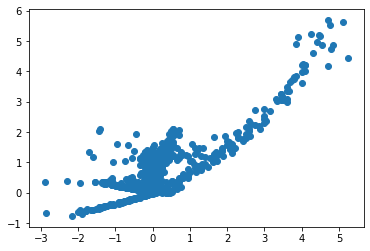

In [89]:
plt.scatter(opt_changes, naive_changes)

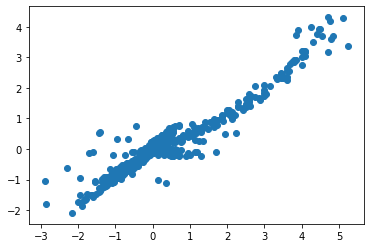

In [90]:
plt.scatter(opt_changes, div_changes)

In [113]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(opt_changes, naive_changes)

In [114]:
print(r_value)

0.8107811233788362


In [115]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(opt_changes, div_changes)

In [116]:
print(r_value)

0.9538099966642241


In [119]:
def deltas(ticker):
    consolidated = merge_before(ticker, 1)
    #filter out by volume and exOrEffDate and want delta
    filtered = consolidated[consolidated['volume'] > 0]
    filtered = filtered[filtered.exOrEffDate.notnull()]
    filtered = filtered[filtered.delta.notnull()]
    filtered = filtered[filtered.cp_flag == 'P']
    
    opt_changes = []
    naive_changes = []
    div_changes = []
    print('Data Loaded')
    for index, row in filtered.iterrows():
        try:
            symbol = row['symbol']
            div = float(row['amount'][1:])
            day = next_day(dates, datetime.strptime(row['date_x'], '%Y%m%d'))
            a = consolidated[(consolidated.DATE == np.datetime64(day)) & (consolidated.symbol == symbol)]
            next_row = a.iloc[0]
            price_change = next_row['PRC']-row['PRC']
            opt_change = next_row['best_offer']-row['best_offer']
            delta = row['delta']
            naive_pricing = delta*price_change
            div_pricing = delta*(price_change+div)

            #print(np.isnan(opt_change),np.isnan(naive_pricing),np.isnan(div_pricing))

            if not np.isnan(opt_change) and not  np.isnan(naive_pricing) and not np.isnan(div_pricing):
                print(price_change, opt_change, row['delta'], naive_pricing, div_pricing)
                opt_changes.append(opt_change)
                naive_changes.append(naive_pricing)
                div_changes.append(div_pricing)
        except:
            pass
    return opt_changes, naive_changes, div_changes

In [140]:
def analyze(opt_changes, naive_changes, div_changes):
    plt.scatter(naive_changes, opt_changes)
    plt.title("NAIVE")
    plt.show()
    plt.scatter(naive_changes, div_changes)
    plt.title("DIV")
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(naive_changes, opt_changes)
    print("NAIVE METHOD slope: {} \t intercept: {}\t r_value: {} \t p_value {}: \tstd_err: {}".format(slope, intercept, r_value, p_value, std_err))
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(div_changes, opt_changes)
    print("DIV METHOD slope: {} \t intercept: {}\t r_value: {} \t p_value {}: \tstd_err: {}".format(slope, intercept, r_value, p_value, std_err))

In [121]:
opt_changes, naive_changes, div_changes = deltas('AAPL')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data Loaded
-0.27000000000001023 -0.009999999999999998 -0.010269 0.0027726300000001053 -0.002567249999999895
-0.27000000000001023 -0.009999999999999998 -0.010903 0.0029438100000001113 -0.0027257499999998884
-0.27000000000001023 -0.02 -0.013381 0.003612870000000137 -0.0033452499999998635
-0.27000000000001023 -0.02 -0.016109000000000002 0.004349430000000165 -0.004027249999999836
-0.27000000000001023 -0.030000000000000002 -0.020919999999999998 0.005648400000000214 -0.005229999999999786
-0.27000000000001023 -0.039999999999999994 -0.026204 0.007075080000000269 -0.006550999999999732
-0.27000000000001023 -0.04000000000000001 -0.032137 0.008676990000000329 -0.008034249999999672
-0.27000000000001023 -0.07 -0.044235000000000003 0.011943450000000454 -0.01105874999999955
-0.27000000000001023 -0.07999999999999999 -0.055955 0.015107850000000572 -0.013988749999999429
-0.27000000000001023 -0.09000000000000001 -0.071388 0.019274760000000727 -0.01784699999999927
-0.27000000000001023 -0.14 -0.09975099999

-0.27000000000001023 -0.40000000000000036 -0.9686600000000001 0.26153820000000993 -0.24216499999999014
-0.27000000000001023 -0.40000000000000036 -0.9700770000000001 0.26192079000000995 -0.2425192499999901
-0.27000000000001023 -0.45000000000000107 -0.9713229999999999 0.2622572100000099 -0.24283074999999008
-0.27000000000001023 -0.5 -0.972426 0.26255502000000996 -0.24310649999999007
-0.27000000000001023 -0.4499999999999993 -0.981136 0.26490672000001003 -0.24528399999998998
-0.27000000000001023 -0.3999999999999986 -0.991915 0.26781705000001016 -0.24797874999998987
-0.27000000000001023 -0.9499999999999993 -0.965007 0.26055189000000983 -0.24125174999999013
-0.27000000000001023 0.0 -0.000923 0.00024921000000000947 -0.00023074999999999057
-0.27000000000001023 0.0 -0.001057 0.0002853900000000108 -0.0002642499999999892
-0.27000000000001023 -0.009999999999999998 -0.004612 0.0012452400000000472 -0.0011529999999999529
-0.27000000000001023 0.0 -0.0086 0.002322000000000088 -0.002149999999999912
-0.2

-0.27000000000001023 -0.3000000000000007 -0.865952 0.23380704000000888 -0.21648799999999116
-0.27000000000001023 -0.1999999999999993 -0.895144 0.24168888000000918 -0.22378599999999088
-0.27000000000001023 -0.049999999999998934 -0.9040879999999999 0.24410376000000922 -0.22602199999999073
-0.27000000000001023 -0.40000000000000036 -0.93824 0.25332480000000956 -0.23455999999999042
-0.27000000000001023 -0.3999999999999986 -0.951016 0.2567743200000097 -0.23775399999999028
-0.27000000000001023 -0.34999999999999787 -0.958348 0.2587539600000098 -0.2395869999999902
-0.27000000000001023 -0.03999999999999998 -0.034825999999999996 0.009403020000000355 -0.008706499999999643
-0.27000000000001023 0.06 -0.059908 0.016175160000000615 -0.014976999999999388
-0.27000000000001023 -0.08000000000000007 -0.11230699999999999 0.030322890000001147 -0.02807674999999885
-0.27000000000001023 -0.1100000000000001 -0.186576 0.05037552000000191 -0.04664399999999809
-0.27000000000001023 -0.17000000000000037 -0.3101440000

-0.27000000000001023 0.0 -0.44163100000000005 0.11924037000000454 -0.1104077499999955
-0.27000000000001023 0.0 -0.45578 0.12306060000000467 -0.11394499999999536
-0.27000000000001023 0.0 -0.469767 0.12683709000000482 -0.1174417499999952
-0.27000000000001023 0.0 -0.48369799999999996 0.13059846000000494 -0.12092449999999505
-0.27000000000001023 0.0 -0.497942 0.1344443400000051 -0.12448549999999492
-0.27000000000001023 0.0 -0.512058 0.13825566000000525 -0.12801449999999479
-0.27000000000001023 0.0 -0.52627 0.14209290000000538 -0.13156749999999462
-0.27000000000001023 0.0 -0.5403220000000001 0.14588694000000554 -0.1350804999999945
-0.27000000000001023 -0.049999999999998934 -0.568235 0.15342345000000582 -0.1420587499999942
-0.27000000000001023 -0.05000000000000071 -0.5960770000000001 0.1609407900000061 -0.14901924999999394
-0.27000000000001023 -0.09999999999999964 -0.6225890000000001 0.1680990300000064 -0.15564724999999366
-0.27000000000001023 -0.15000000000000036 -0.674636 0.182151720000006

-1.0799999999999983 -0.019999999999999997 -0.008968 0.009685439999999984 0.005022079999999984
-1.0799999999999983 -0.019999999999999997 -0.009444 0.010199519999999983 0.005288639999999983
-1.0799999999999983 -0.019999999999999997 -0.009972 0.010769759999999982 0.005584319999999983
-1.0799999999999983 -0.019999999999999997 -0.010563 0.011408039999999982 0.005915279999999981
-1.0799999999999983 -0.019999999999999997 -0.011228 0.01212623999999998 0.00628767999999998
-1.0799999999999983 -0.019999999999999997 -0.011984 0.012942719999999979 0.006711039999999979
-1.0799999999999983 -0.009999999999999998 -0.012852 0.013880159999999978 0.007197119999999978
-1.0799999999999983 -0.02 -0.017917 0.01935035999999997 0.010033519999999968
-1.0799999999999983 -0.02 -0.019426 0.020980079999999967 0.010878559999999966
-1.0799999999999983 -0.02 -0.021228999999999998 0.022927319999999963 0.011888239999999961
-1.0799999999999983 -0.020000000000000004 -0.028179000000000003 0.030433319999999955 0.015780239999

-1.0799999999999983 0.010000000000000009 -0.042201999999999996 0.04557815999999992 0.023633119999999924
-1.0799999999999983 0.010000000000000009 -0.049726 0.05370407999999991 0.027846559999999913
-1.0799999999999983 0.010000000000000009 -0.058788 0.0634910399999999 0.0329212799999999
-1.0799999999999983 0.010000000000000009 -0.069521 0.07508267999999987 0.03893175999999988
-1.0799999999999983 0.0 -0.083026 0.08966807999999986 0.04649455999999986
-1.0799999999999983 0.010000000000000009 -0.099477 0.10743515999999982 0.055707119999999825
-1.0799999999999983 0.020000000000000018 -0.119966 0.1295632799999998 0.06718095999999979
-1.0799999999999983 0.010000000000000009 -0.148519 0.16040051999999977 0.08317063999999975
-1.0799999999999983 0.030000000000000027 -0.180424 0.19485791999999968 0.10103743999999969
-1.0799999999999983 0.050000000000000044 -0.221818 0.2395634399999996 0.1242180799999996
-1.0799999999999983 0.06000000000000005 -0.269402 0.2909541599999995 0.15086511999999952
-1.07999

-1.0799999999999983 0.20000000000000018 -0.616611 0.6659398799999989 0.34530215999999897
-1.0799999999999983 0.1999999999999993 -0.666603 0.7199312399999988 0.3732976799999988
-1.0799999999999983 0.25 -0.754534 0.8148967199999988 0.4225390399999987
-1.0799999999999983 0.3000000000000007 -0.851275 0.9193769999999986 0.47671399999999853
-1.0799999999999983 0.009999999999999995 -0.015877000000000002 0.017147159999999974 0.008891119999999975
-1.0799999999999983 0.03 -0.024922 0.02691575999999996 0.013956319999999956
-1.0799999999999983 0.05000000000000002 -0.039169 0.042302519999999934 0.021934639999999932
-1.0799999999999983 0.03999999999999998 -0.044226 0.047764079999999924 0.024766559999999924
-1.0799999999999983 0.04999999999999999 -0.049547 0.053510759999999914 0.027746319999999915
-1.0799999999999983 0.04999999999999999 -0.056472 0.06098975999999991 0.0316243199999999
-1.0799999999999983 0.050000000000000044 -0.064377 0.0695271599999999 0.03605111999999989
-1.0799999999999983 0.04999

-1.0799999999999983 0.009999999999999995 -0.006523999999999999 0.0070459199999999885 0.0036534399999999883
-1.0799999999999983 0.020000000000000004 -0.007540000000000001 0.008143199999999988 0.004222399999999987
-1.0799999999999983 0.010000000000000009 -0.008196 0.008851679999999987 0.004589759999999986
-1.0799999999999983 0.009999999999999995 -0.008884999999999999 0.009595799999999984 0.004975599999999984
-1.0799999999999983 0.020000000000000004 -0.010415 0.011248199999999983 0.005832399999999982
-1.0799999999999983 0.020000000000000018 -0.011192 0.012087359999999981 0.006267519999999981
-1.0799999999999983 0.01999999999999999 -0.012423 0.013416839999999979 0.006956879999999979
-1.0799999999999983 0.01999999999999999 -0.014122 0.015251759999999975 0.007908319999999976
-1.0799999999999983 0.020000000000000018 -0.01548 0.016718399999999974 0.008668799999999973
-1.0799999999999983 0.03 -0.016911000000000002 0.018263879999999975 0.009470159999999972
-1.0799999999999983 0.03999999999999998

0.25 -0.75 -0.9839530000000001 -0.24598825000000002 -0.75764381
0.25 -0.8499999999999979 -0.9734139999999999 -0.24335349999999997 -0.7495287799999999
0.25 -0.8499999999999979 -0.974418 -0.2436045 -0.75030186
0.25 -0.75 -0.9852549999999999 -0.24631374999999997 -0.7586463499999999
0.25 -0.5 -0.97711 -0.2442775 -0.7523747000000001
0.25 0.0 -0.002605 -0.00065125 -0.00200585
0.25 0.0 -0.0027670000000000004 -0.0006917500000000001 -0.0021305900000000003
0.25 0.019999999999999997 -0.002951 -0.00073775 -0.0022722700000000003
0.25 0.009999999999999998 -0.005559000000000001 -0.0013897500000000001 -0.004280430000000001
0.25 0.019999999999999997 -0.0034 -0.00085 -0.002618
0.25 0.0 -0.0036799999999999997 -0.0009199999999999999 -0.0028336
0.25 0.0 -0.0038380000000000003 -0.0009595000000000001 -0.0029552600000000004
0.25 0.0 -0.004009 -0.00100225 -0.0030869300000000003
0.25 0.0 -0.0041979999999999995 -0.0010494999999999999 -0.0032324599999999995
0.25 -0.01 -0.007698 -0.0019245 -0.00592746
0.25 -0.01 -

0.25 -0.43999999999999995 -0.5372100000000001 -0.13430250000000002 -0.41365170000000007
0.25 -0.46999999999999975 -0.575869 -0.14396725 -0.44341913
0.25 -0.4900000000000002 -0.6137699999999999 -0.15344249999999998 -0.47260289999999994
0.25 -0.56 -0.649766 -0.1624415 -0.50031982
0.25 -0.5499999999999998 -0.686559 -0.17163975 -0.52865043
0.25 -0.6499999999999999 -0.721312 -0.180328 -0.5554102399999999
0.25 -0.6500000000000004 -0.756996 -0.189249 -0.58288692
0.25 -0.6500000000000004 -0.734829 -0.18370725 -0.5658183299999999
0.25 -0.6500000000000004 -0.7843359999999999 -0.19608399999999998 -0.6039387199999999
0.25 -0.75 -0.861189 -0.21529725 -0.66311553
0.25 -0.7500000000000009 -0.890159 -0.22253975 -0.68542243
0.25 -0.75 -0.9076190000000001 -0.22690475000000002 -0.69886663
0.25 -0.8000000000000007 -0.949832 -0.237458 -0.7313706400000001
0.25 -0.75 -0.960564 -0.240141 -0.73963428
0.25 -0.75 -0.9620340000000001 -0.24050850000000001 -0.74076618
0.25 -0.75 -0.968298 -0.2420745 -0.74558946
0.2

0.25 -0.07999999999999996 -0.11810899999999999 -0.029527249999999998 -0.09094392999999999
0.25 -0.12 -0.172611 -0.04315275 -0.13291047
0.25 -0.17999999999999994 -0.24550500000000003 -0.06137625000000001 -0.18903885000000004
0.25 -0.25 -0.33562600000000004 -0.08390650000000001 -0.25843202000000004
0.25 -0.3400000000000003 -0.439961 -0.10999025 -0.33876997
0.25 -0.40000000000000036 -0.5508069999999999 -0.13770174999999998 -0.42412139
0.25 -0.5 -0.614592 -0.153648 -0.47323584
0.25 -0.6500000000000004 -0.765594 -0.1913985 -0.58950738
0.25 -0.7000000000000011 -0.872733 -0.21818325 -0.67200441
0.25 -0.75 -0.932299 -0.23307475 -0.71787023
0.25 -0.7999999999999972 -0.9558549999999999 -0.23896374999999997 -0.73600835
0.25 -0.8000000000000007 -0.9686670000000001 -0.24216675000000001 -0.7458735900000001
0.25 -0.8000000000000043 -0.9757129999999999 -0.24392824999999999 -0.75129901
0.25 0.0 -0.006344 -0.001586 -0.00488488
0.25 0.0 -0.010085 -0.00252125 -0.00776545
0.25 -0.010000000000000009 -0.0168

-0.9500000000000028 0.0 -0.004994 0.004744300000000015 0.0018977200000000144
-0.9500000000000028 0.0 -0.005633 0.005351350000000016 0.0021405400000000163
-0.9500000000000028 -0.01 -0.015328 0.014561600000000043 0.005824640000000044
-0.9500000000000028 0.0 -0.017912 0.017016400000000053 0.006806560000000052
-0.9500000000000028 -0.010000000000000002 -0.035941 0.0341439500000001 0.013657580000000105
-0.9500000000000028 -0.019999999999999997 -0.056938 0.05409110000000016 0.021636440000000166
-0.9500000000000028 -0.010000000000000009 -0.07607699999999999 0.0722731500000002 0.028909260000000218
-0.9500000000000028 -0.01999999999999999 -0.12259300000000001 0.11646335000000035 0.04658534000000036
-0.9500000000000028 -0.010000000000000009 -0.182402 0.17328190000000052 0.06931276000000053
-0.9500000000000028 0.010000000000000009 -0.26110900000000004 0.2480535500000008 0.09922142000000077
-0.9500000000000028 0.03999999999999998 -0.359214 0.341253300000001 0.13650132000000104
-0.9500000000000028 0

-0.9500000000000028 0.07999999999999996 -0.123615 0.11743425000000035 0.04697370000000036
-0.9500000000000028 0.10999999999999999 -0.156047 0.14824465000000042 0.059297860000000445
-0.9500000000000028 0.13 -0.197372 0.18750340000000054 0.07500136000000057
-0.9500000000000028 0.15000000000000002 -0.247139 0.2347820500000007 0.09391282000000072
-0.9500000000000028 0.16999999999999993 -0.274947 0.2611996500000008 0.1044798600000008
-0.9500000000000028 0.18000000000000016 -0.30424 0.2890280000000009 0.11561120000000089
-0.9500000000000028 0.20999999999999996 -0.33570500000000003 0.318919750000001 0.12756790000000098
-0.9500000000000028 0.21999999999999997 -0.368909 0.350463550000001 0.14018542000000106
-0.9500000000000028 0.24 -0.40313499999999997 0.38297825000000113 0.15319130000000114
-0.9500000000000028 0.2500000000000002 -0.43872799999999995 0.4167916000000012 0.16671664000000125
-0.9500000000000028 0.30000000000000027 -0.47506499999999996 0.4513117500000013 0.18052470000000137
-0.9500

-0.9500000000000028 0.6000000000000014 -0.8689110000000001 0.8254654500000026 0.33018618000000255
-0.9500000000000028 0.5 -0.941543 0.8944658500000027 0.35778634000000276
-0.9500000000000028 0.6499999999999986 -0.9798209999999999 0.9308299500000027 0.37233198000000284
-0.9500000000000028 0.0 -0.0032259999999999997 0.0030647000000000087 0.0012258800000000093
-0.9500000000000028 -0.010000000000000009 -0.009028 0.008576600000000024 0.003430640000000026
-0.9500000000000028 0.0 -0.015149000000000001 0.014391550000000045 0.005756620000000044
-0.9500000000000028 0.0 -0.02667 0.025336500000000074 0.010134600000000077
-0.9500000000000028 0.019999999999999962 -0.047124 0.044767800000000135 0.017907120000000137
-0.9500000000000028 0.05999999999999994 -0.09112 0.08656400000000027 0.03462560000000026
-0.9500000000000028 0.1399999999999999 -0.179925 0.17092875000000052 0.06837150000000052
-0.9500000000000028 0.17000000000000015 -0.24809299999999998 0.23568835000000068 0.0942753400000007
-0.950000000

0.0799999999999983 -0.01 -0.007548999999999999 -0.0006039199999999871 -0.004906849999999986
0.0799999999999983 -0.01 -0.005644 -0.00045151999999999036 -0.0036685999999999898
0.0799999999999983 -0.01 -0.008084000000000001 -0.0006467199999999863 -0.005254599999999986
0.0799999999999983 -0.01 -0.006065 -0.0004851999999999897 -0.003942249999999989
0.0799999999999983 -0.01 -0.0087 -0.0006959999999999852 -0.005654999999999985
0.0799999999999983 -0.01 -0.009420999999999999 -0.0007536799999999838 -0.006123649999999983
0.0799999999999983 -0.019999999999999997 -0.012301000000000001 -0.0009840799999999792 -0.00799564999999998
0.0799999999999983 -0.019999999999999997 -0.012853 -0.001028239999999978 -0.008354449999999977
0.0799999999999983 -0.019999999999999997 -0.015971 -0.0012776799999999727 -0.010381149999999971
0.0799999999999983 -0.019999999999999997 -0.014127 -0.001130159999999976 -0.009182549999999975
0.0799999999999983 -0.019999999999999997 -0.017625 -0.0014099999999999699 -0.01145624999999

0.0799999999999983 -0.07 -0.07077699999999999 -0.005662159999999879 -0.046005049999999874
0.0799999999999983 -0.07999999999999999 -0.08054700000000001 -0.006443759999999864 -0.05235554999999986
0.0799999999999983 -0.08000000000000002 -0.090999 -0.007279919999999844 -0.05914934999999984
0.0799999999999983 -0.16000000000000003 -0.137946 -0.011035679999999767 -0.08966489999999977
0.0799999999999983 -0.19 -0.180851 -0.014468079999999692 -0.11755314999999969
0.0799999999999983 -0.22000000000000003 -0.23338299999999998 -0.0186706399999996 -0.15169894999999958
0.0799999999999983 -0.28 -0.299444 -0.023955519999999488 -0.19463859999999947
0.0799999999999983 -0.36 -0.378164 -0.030253119999999356 -0.24580659999999935
0.0799999999999983 -0.42999999999999994 -0.46642799999999995 -0.0373142399999992 -0.3031781999999992
0.0799999999999983 -0.5000000000000002 -0.558492 -0.044679359999999044 -0.363019799999999
0.0799999999999983 -0.5699999999999998 -0.647492 -0.05179935999999889 -0.42086979999999885
0.

0.0799999999999983 -0.4099999999999997 -0.327171 -0.026173679999999443 -0.2126611499999994
0.0799999999999983 -0.5 -0.47472299999999995 -0.03797783999999919 -0.30856994999999915
0.0799999999999983 -0.5999999999999996 -0.627156 -0.05017247999999894 -0.40765139999999894
0.0799999999999983 -0.6500000000000004 -0.758096 -0.060647679999998705 -0.49276239999999866
0.0799999999999983 -0.6500000000000004 -0.850319 -0.06802551999999855 -0.5527073499999985
0.0799999999999983 -1.0 -0.913963 -0.07311703999999844 -0.5940759499999984
0.0799999999999983 -0.009999999999999981 -0.020084 -0.0016067199999999658 -0.013054599999999965
0.0799999999999983 -0.030000000000000027 -0.030993 -0.002479439999999947 -0.020145449999999947
0.0799999999999983 -0.04999999999999999 -0.047323000000000004 -0.0037858399999999197 -0.030759949999999918
0.0799999999999983 -0.12 -0.076749 -0.006139919999999869 -0.049886849999999865
0.0799999999999983 -0.18000000000000005 -0.126378 -0.010110239999999784 -0.08214569999999977
0.07

-1.7600000000000051 -0.019999999999999997 -0.013212 0.023253120000000068 0.01572228000000007
-1.7600000000000051 -0.019999999999999997 -0.014297 0.025162720000000076 0.017013430000000076
-1.7600000000000051 -0.019999999999999997 -0.015584 0.027427840000000082 0.018544960000000082
-1.7600000000000051 -0.009999999999999998 -0.017138999999999998 0.030164640000000083 0.02039541000000009
-1.7600000000000051 -0.02 -0.024503 0.04312528000000013 0.02915857000000013
-1.7600000000000051 -0.02 -0.027585000000000002 0.048549600000000144 0.03282615000000015
-1.7600000000000051 -0.020000000000000004 -0.037877999999999995 0.06666528000000019 0.045074820000000196
-1.7600000000000051 0.0 -0.051111000000000004 0.08995536000000026 0.06082209000000027
-1.7600000000000051 0.010000000000000009 -0.079428 0.1397932800000004 0.09451932000000042
-1.7600000000000051 0.09 -0.14899300000000001 0.2622276800000008 0.1773016700000008
-1.7600000000000051 0.25999999999999995 -0.277848 0.4890124800000014 0.3306391200000

-1.7600000000000051 1.0 -0.674216 1.1866201600000035 0.8023170400000036
-1.7600000000000051 1.0 -0.733133 1.290314080000004 0.8724282700000039
-1.7600000000000051 1.0499999999999998 -0.78435 1.380456000000004 0.9333765000000042
-1.7600000000000051 1.1000000000000005 -0.837733 1.4744100800000042 0.9969022700000043
-1.7600000000000051 1.1500000000000004 -0.8802770000000001 1.5492875200000047 1.0475296300000048
-1.7600000000000051 1.200000000000001 -0.9599280000000001 1.6894732800000052 1.1423143200000052
-1.7600000000000051 0.07999999999999999 -0.036454 0.06415904000000018 0.04338026000000019
-1.7600000000000051 0.21000000000000002 -0.09401799999999999 0.16547168000000045 0.11188142000000048
-1.7600000000000051 0.25 -0.109507 0.19273232000000054 0.13031333000000056
-1.7600000000000051 0.28 -0.128477 0.22611952000000068 0.1528876300000007
-1.7600000000000051 0.32000000000000006 -0.150901 0.2655857600000008 0.1795721900000008
-1.7600000000000051 0.37 -0.176778 0.3111292800000009 0.21036582

-1.7600000000000051 1.0999999999999979 -0.727139 1.2797646400000038 0.8652954100000038
-1.7600000000000051 0.01999999999999999 -0.009076 0.01597376000000005 0.010800440000000048
-1.7600000000000051 0.03 -0.014425 0.025388000000000074 0.017165750000000077
-1.7600000000000051 0.03999999999999998 -0.022389 0.039404640000000116 0.026642910000000117
-1.7600000000000051 0.06000000000000005 -0.034770999999999996 0.06119696000000017 0.041377490000000176
-1.7600000000000051 0.1100000000000001 -0.050582 0.08902432000000027 0.060192580000000266
-1.7600000000000051 0.1399999999999999 -0.073641 0.12960816000000036 0.08763279000000039
-1.7600000000000051 0.18999999999999995 -0.105299 0.18532624000000056 0.12530581000000057
-1.7600000000000051 0.22999999999999976 -0.125277 0.22048752000000063 0.14907963000000066
-1.7600000000000051 0.27 -0.14837999999999998 0.26114880000000074 0.17657220000000076
-1.7600000000000051 0.31000000000000005 -0.17440899999999998 0.30695984000000087 0.20754671000000088
-1.7

0.3800099999999986 -0.03 -0.025373 -0.009641993729999965 -0.024104603729999962
0.3800099999999986 -0.03 -0.029024 -0.01102941023999996 -0.02757309023999996
0.3800099999999986 -0.039999999999999994 -0.032998 -0.012539569979999955 -0.03134842997999995
0.3800099999999986 -0.03 -0.035033 -0.013312890329999952 -0.03328170032999995
0.3800099999999986 -0.039999999999999994 -0.039813999999999995 -0.015129718139999944 -0.03782369813999994
0.3800099999999986 -0.04000000000000001 -0.045167 -0.017163911669999938 -0.042909101669999936
0.3800099999999986 -0.03 -0.048623 -0.01847722622999993 -0.04619233622999993
0.3800099999999986 -0.039999999999999994 -0.05822000000000001 -0.022124182199999922 -0.05530958219999992
0.3800099999999986 -0.05000000000000002 -0.069141 -0.026274271409999904 -0.0656846414099999
0.3800099999999986 -0.07 -0.084614 -0.032154166139999885 -0.08038414613999988
0.3800099999999986 -0.09 -0.10803299999999999 -0.041053620329999846 -0.10263243032999984
0.3800099999999986 -0.13 -0.141

0.3800099999999986 -0.5 -0.513935 -0.1953004393499993 -0.4882433893499993
0.3800099999999986 -0.6000000000000001 -0.574995 -0.21850384994999922 -0.5462509999499993
0.3800099999999986 -0.5999999999999996 -0.6351359999999999 -0.2413580313599991 -0.603385551359999
0.3800099999999986 -0.6000000000000005 -0.693902 -0.26368969901999906 -0.6592138390199991
0.3800099999999986 -0.75 -0.741754 -0.281873937539999 -0.704673717539999
0.3800099999999986 -0.8000000000000007 -0.8306790000000001 -0.3156663267899989 -0.7891533567899989
0.3800099999999986 0.0 -0.013647999999999999 -0.005186376479999981 -0.01296573647999998
0.3800099999999986 -0.020000000000000018 -0.022557 -0.008571885569999969 -0.021429375569999968
0.3800099999999986 -0.03 -0.036306 -0.013796643059999949 -0.034491063059999945
0.3800099999999986 -0.04999999999999999 -0.060882000000000006 -0.02313576881999992 -0.05783850881999992
0.3800099999999986 -0.09999999999999998 -0.114976 -0.04369202975999984 -0.10922834975999983
0.3800099999999986

0.3800099999999986 -0.08999999999999986 -0.07155399999999999 -0.0271912355399999 -0.0679770155399999
0.3800099999999986 -0.1100000000000001 -0.08429099999999999 -0.03203142290999988 -0.08007729290999988
0.3800099999999986 -0.10000000000000009 -0.116426 -0.04424304425999984 -0.11060586425999984
0.3800099999999986 -0.14000000000000012 -0.15173499999999998 -0.05766081734999978 -0.14414976734999976
0.3800099999999986 -0.20000000000000018 -0.194218 -0.07380478217999974 -0.18450904217999972
0.3800099999999986 -0.25 -0.24413600000000002 -0.09277412135999967 -0.23193164135999966
0.3800099999999986 -0.34999999999999964 -0.300789 -0.11430282788999957 -0.28575255788999954
0.3800099999999986 -0.40000000000000036 -0.362739 -0.13784444738999949 -0.3446056773899995
0.3800099999999986 -0.45000000000000107 -0.42886199999999997 -0.1629718486199994 -0.4074231886199994
0.3800099999999986 -0.5 -0.497374 -0.1890070937399993 -0.47251027373999926
0.3800099999999986 -0.5500000000000007 -0.565702 -0.21497241701

0.6900100000000009 -0.009999999999999998 -0.004339 -0.002993953390000004 -0.005727523390000004
0.6900100000000009 0.0 -0.005877 -0.004055188770000005 -0.007757698770000005
0.6900100000000009 0.0 -0.006072999999999999 -0.004190430730000005 -0.008016420730000005
0.6900100000000009 0.0 -0.011545 -0.00796616545000001 -0.015239515450000008
0.6900100000000009 -0.009999999999999995 -0.014593 -0.010069315930000013 -0.01926290593000001
0.6900100000000009 -0.009999999999999995 -0.015222 -0.010503332220000014 -0.02009319222000001
0.6900100000000009 -0.010000000000000009 -0.018050999999999998 -0.012455370510000015 -0.023827500510000012
0.6900100000000009 -0.010000000000000009 -0.018896 -0.013038428960000016 -0.024942908960000013
0.6900100000000009 -0.009999999999999995 -0.022055 -0.01521817055000002 -0.02911282055000002
0.6900100000000009 -0.009999999999999995 -0.025422999999999998 -0.01754212423000002 -0.03355861423000002
0.6900100000000009 -0.020000000000000004 -0.029048 -0.020043410480000027 -0

0.6900100000000009 -0.17000000000000004 -0.144342 -0.09959742342000012 -0.1905328834200001
0.6900100000000009 -0.20000000000000007 -0.166743 -0.11505433743000015 -0.22010242743000014
0.6900100000000009 -0.2300000000000001 -0.19175699999999998 -0.13231424757000015 -0.25312115757000014
0.6900100000000009 -0.26 -0.21974000000000002 -0.1516227974000002 -0.2900589974000002
0.6900100000000009 -0.31000000000000005 -0.251237 -0.1733560423700002 -0.3316353523700002
0.6900100000000009 -0.3500000000000001 -0.28618499999999997 -0.19747051185000022 -0.3777670618500002
0.6900100000000009 -0.4099999999999999 -0.323675 -0.22333898675000027 -0.42725423675000024
0.6900100000000009 -0.4600000000000002 -0.364076 -0.25121608076000035 -0.4805839607600003
0.6900100000000009 -0.6200000000000001 -0.47401800000000005 -0.32707716018000044 -0.6257085001800005
0.6900100000000009 -0.7999999999999998 -0.586916 -0.40497790916000054 -0.7747349891600005
0.6900100000000009 -0.9500000000000002 -0.6923590000000001 -0.4777

0.6900100000000009 -0.010000000000000009 -0.018047999999999998 -0.012453300480000014 -0.023823540480000013
0.6900100000000009 -0.010000000000000009 -0.026748 -0.018456387480000024 -0.03530762748000002
0.6900100000000009 -0.010000000000000009 -0.03974 -0.027420997400000036 -0.05245719740000003
0.6900100000000009 -0.020000000000000018 -0.057562999999999996 -0.03971904563000005 -0.07598373563000003
0.6900100000000009 -0.039999999999999813 -0.082125 -0.056667071250000076 -0.10840582125000008
0.6900100000000009 -0.06999999999999984 -0.114926 -0.07930008926000011 -0.15170346926000008
0.6900100000000009 -0.1200000000000001 -0.157623 -0.10876144623000016 -0.20806393623000013
0.6900100000000009 -0.20000000000000018 -0.210216 -0.14505114216000017 -0.27748722216000016
0.6900100000000009 -0.2999999999999998 -0.273902 -0.18899511902000024 -0.3615533790200002
0.6900100000000009 -0.35000000000000053 -0.345273 -0.2382418227300003 -0.4557638127300003
0.6900100000000009 -0.4499999999999993 -0.4233659999

-5.739990000000006 0.18000000000000002 -0.022359999999999998 0.12834617640000012 0.11425937640000013
-5.739990000000006 0.21 -0.024401 0.14006149599000015 0.12468886599000015
-5.739990000000006 0.23000000000000004 -0.027627999999999996 0.15858444372000013 0.14117880372000013
-5.739990000000006 0.26 -0.032106 0.18428811894000022 0.16406133894000022
-5.739990000000006 0.31 -0.036889 0.2117424911100002 0.1885024211100002
-5.739990000000006 0.35 -0.042046 0.24134361954000025 0.21485463954000025
-5.739990000000006 0.4099999999999999 -0.04766 0.2735679234000003 0.24354212340000028
-5.739990000000006 0.49999999999999994 -0.055875 0.32072194125000036 0.28552069125000035
-5.739990000000006 0.62 -0.065809 0.37774300191000043 0.3362833319100004
-5.739990000000006 1.02 -0.100186 0.5750666381400006 0.5119494581400006
-5.739990000000006 1.7100000000000002 -0.164721 0.945496892790001 0.8417226627900011
-5.739990000000006 2.63 -0.282125 1.6193946787500018 1.4416559287500017
-5.739990000000006 3.650000

-5.739990000000006 0.5900000000000001 -0.037756 0.21671906244000022 0.19293278244000023
-5.739990000000006 0.78 -0.057525 0.33019292475000034 0.29395217475000035
-5.739990000000006 0.77 -0.06399099999999999 0.36730770009000036 0.32699337009000035
-5.739990000000006 0.9700000000000001 -0.078997 0.45344199003000046 0.4036738800300005
-5.739990000000006 1.0299999999999998 -0.088018 0.5052224398200005 0.4497710998200005
-5.739990000000006 1.11 -0.098201 0.5636727579900006 0.5018061279900006
-5.739990000000006 1.22 -0.1083 0.6216409170000006 0.5534119170000006
-5.739990000000006 1.25 -0.122019 0.7003878398100007 0.6235158698100007
-5.739990000000006 1.39 -0.13603800000000002 0.7808567596200009 0.695152819620001
-5.739990000000006 1.48 -0.151205 0.8679151879500009 0.7726560379500009
-5.739990000000006 1.6099999999999999 -0.167881 0.963635261190001 0.857870231190001
-5.739990000000006 1.73 -0.18637 1.069761936300001 0.9523488363000011
-5.739990000000006 2.09 -0.24028899999999997 1.37925645711

-5.739990000000006 0.12000000000000002 -0.009612 0.05517278388000006 0.04911722388000006
-5.739990000000006 0.13999999999999999 -0.011432 0.06561956568000006 0.05841740568000007
-5.739990000000006 0.21999999999999997 -0.016493999999999998 0.09467539506000008 0.08428417506000009
-5.739990000000006 0.43999999999999995 -0.032307 0.1854418569300002 0.16508844693000022
-5.739990000000006 0.5800000000000001 -0.045194 0.25941310806000023 0.23094088806000027
-5.739990000000006 0.73 -0.062471000000000006 0.3585829152900004 0.3192261852900004
-5.739990000000006 0.9400000000000002 -0.085518 0.49087246482000046 0.4369961248200005
-5.739990000000006 1.1600000000000001 -0.11505599999999999 0.6604202894400006 0.5879350094400007
-5.739990000000006 1.5000000000000004 -0.152199 0.873620738010001 0.7777353680100009
-5.739990000000006 1.8000000000000003 -0.19709200000000002 1.1313061090800012 1.0071381490800013
-5.739990000000006 2.1000000000000005 -0.25058800000000003 1.4383726141200017 1.280502174120001

-1.210000000000008 0.039999999999999813 -0.317392 0.38404432000000255 0.18408736000000253
-1.210000000000008 0.15000000000000036 -0.470052 0.5687629200000037 0.27263016000000373
-1.210000000000008 0.25 -0.636224 0.7698310400000051 0.36900992000000504
-1.210000000000008 0.25 -0.787518 0.9528967800000063 0.4567604400000063
-1.210000000000008 0.20000000000000018 -0.8524149999999999 1.0314221500000067 0.49440070000000674
-1.210000000000008 -1.049999999999999 -0.921298 1.1147705800000072 0.5343528400000073
-1.210000000000008 -0.020000000000000004 -0.003863 0.004674230000000031 0.002240540000000031
-1.210000000000008 -0.06 -0.010499 0.012703790000000083 0.006089420000000083
-1.210000000000008 -0.03 -0.009463 0.011450230000000075 0.005488540000000075
-1.210000000000008 -0.039999999999999994 -0.012052 0.014582920000000096 0.006990160000000096
-1.210000000000008 -0.06000000000000001 -0.017988999999999998 0.02176669000000014 0.010433620000000142
-1.210000000000008 -0.04000000000000001 -0.0152460

-1.210000000000008 -0.05 -0.008336 0.010086560000000066 0.0048348800000000665
-1.210000000000008 -0.04000000000000001 -0.010806999999999999 0.013076470000000085 0.006268060000000086
-1.210000000000008 -0.05000000000000002 -0.015296 0.018508160000000124 0.008871680000000121
-1.210000000000008 -0.05000000000000002 -0.021644 0.026189240000000173 0.012553520000000172
-1.210000000000008 -0.03999999999999998 -0.030989 0.03749669000000025 0.017973620000000246
-1.210000000000008 -0.019999999999999962 -0.045038999999999996 0.054497190000000355 0.026122620000000357
-1.210000000000008 -0.050000000000000044 -0.06931799999999999 0.08387478000000054 0.04020444000000055
-1.210000000000008 -0.020000000000000018 -0.105377 0.12750617000000083 0.06111866000000084
-1.210000000000008 -0.010000000000000009 -0.160966 0.19476886000000126 0.09336028000000128
-1.210000000000008 0.06000000000000005 -0.23969400000000002 0.2900297400000019 0.13902252000000193
-1.210000000000008 0.10000000000000009 -0.342671 0.4146

1.260009999999994 -0.22999999999999998 -0.144849 -0.18251118848999914 -0.27376605848999913
1.260009999999994 -0.25 -0.16635899999999998 -0.209614003589999 -0.31442017358999896
1.260009999999994 -0.27 -0.18903399999999998 -0.23818473033999885 -0.3572761503399988
1.260009999999994 -0.36 -0.21861799999999998 -0.27546086617999865 -0.41319020617999863
1.260009999999994 -0.43000000000000016 -0.249352 -0.31418601351999853 -0.4712777735199985
1.260009999999994 -0.4600000000000002 -0.284381 -0.3583229038099983 -0.5374829338099982
1.260009999999994 -0.6500000000000001 -0.387442 -0.48818079441999773 -0.7322692544199977
1.260009999999994 -0.75 -0.5109600000000001 -0.6438147095999971 -0.9657195095999971
1.260009999999994 -0.9000000000000004 -0.64607 -0.8140546606999962 -1.2210787606999962
1.260009999999994 -0.8499999999999996 -0.789855 -0.9952251985499952 -1.4928338485499952
1.260009999999994 -0.6999999999999993 -0.993374 -1.251661173739994 -1.877486793739994
1.260009999999994 -0.16999999999999993 

1.260009999999994 -0.7000000000000011 -0.687859 -0.8667092185899959 -1.300060388589996
1.260009999999994 -0.75 -0.7509600000000001 -0.9462171095999956 -1.4193219095999956
1.260009999999994 -0.8499999999999996 -0.809018 -1.0193707701799952 -1.5290521101799952
1.260009999999994 -0.5499999999999989 -0.9001790000000001 -1.1342345417899948 -1.7013473117899947
1.260009999999994 -0.8500000000000014 -0.9186110000000001 -1.1574590461099947 -1.7361839761099946
1.260009999999994 -0.32000000000000006 -0.182299 -0.2296985629899989 -0.3445469329899989
1.260009999999994 -0.30000000000000004 -0.196723 -0.24787294722999884 -0.37180843722999884
1.260009999999994 -0.3700000000000001 -0.211626 -0.2666508762599988 -0.39997525625999875
1.260009999999994 -0.3900000000000001 -0.227233 -0.2863158523299986 -0.4294726423299986
1.260009999999994 -0.41999999999999993 -0.24421700000000002 -0.3077158621699986 -0.4615725721699986
1.260009999999994 -0.45999999999999996 -0.26214499999999996 -0.3303053214499984 -0.49545

1.260009999999994 0.009999999999999787 -0.115852 -0.14597467851999932 -0.2189614385199993
1.260009999999994 -0.09999999999999964 -0.149827 -0.1887835182699991 -0.28317452826999906
1.260009999999994 -0.04999999999999982 -0.187272 -0.2359645927199989 -0.35394595271999885
1.260009999999994 -0.15000000000000036 -0.23188499999999998 -0.2921774188499986 -0.43826496884999855
1.260009999999994 -0.20000000000000018 -0.28094 -0.3539872093999984 -0.5309794093999983
1.260009999999994 -0.25 -0.33537100000000003 -0.42257081370999805 -0.633854543709998
1.260009999999994 -0.34999999999999964 -0.39385 -0.49625493849999763 -0.7443804384999976
1.260009999999994 -0.40000000000000036 -0.455138 -0.5734784313799973 -0.8602153713799973
1.260009999999994 -0.4499999999999993 -0.518216 -0.6529573421599969 -0.9794334221599968
1.260009999999994 -0.4499999999999993 -0.581647 -0.7328810364699966 -1.0993186464699964
1.260009999999994 -0.5 -0.642209 -0.8091897620899963 -1.2137814320899962
1.260009999999994 -1.44999999

-1.4499899999999855 0.0 -0.005833 0.008457791669999914 0.004199701669999915
-1.4499899999999855 0.009999999999999995 -0.007678 0.011133023219999889 0.005528083219999889
-1.4499899999999855 0.0 -0.007011 0.010165879889999898 0.005047849889999898
-1.4499899999999855 0.010000000000000009 -0.008409999999999999 0.012194415899999877 0.006055115899999877
-1.4499899999999855 -0.010000000000000009 -0.009565 0.013869154349999862 0.006886704349999861
-1.4499899999999855 0.020000000000000004 -0.01085 0.015732391499999842 0.007811891499999842
-1.4499899999999855 -0.009999999999999995 -0.015526 0.022512544739999776 0.011178564739999775
-1.4499899999999855 0.020000000000000004 -0.017321 0.02511527678999975 0.012470946789999748
-1.4499899999999855 -0.01999999999999999 -0.022059 0.03198532940999968 0.01588225940999968
-1.4499899999999855 -0.03 -0.029263 0.042431057369999574 0.021069067369999576
-1.4499899999999855 -0.04000000000000001 -0.036567 0.053021784329999475 0.02632787432999947
-1.44998999999998

-1.4499899999999855 -0.3900000000000001 -0.145603 0.2111228939699979 0.10483270396999789
-1.4499899999999855 -0.8300000000000001 -0.198259 0.2874735674099971 0.14274449740999712
-1.4499899999999855 -0.8500000000000001 -0.246644 0.35763133355999643 0.17758121355999643
-1.4499899999999855 -0.8000000000000003 -0.299158 0.43377610841999564 0.21539076841999563
-1.4499899999999855 -0.7999999999999998 -0.358458 0.5197605154199948 0.2580861754199948
-1.4499899999999855 -0.8499999999999996 -0.42336999999999997 0.6138822662999938 0.3048221662999938
-1.4499899999999855 -0.15000000000000036 -0.492935 0.7147508206499928 0.35490827064999286
-1.4499899999999855 -0.6500000000000004 -0.561221 0.8137648377899918 0.40407350778999185
-1.4499899999999855 0.03 -0.00402 0.005828959799999942 0.0028943597999999417
-1.4499899999999855 0.01999999999999999 -0.005125 0.007431198749999926 0.0036899487499999256
-1.4499899999999855 -0.009999999999999995 -0.007506999999999999 0.01088507492999989 0.00540496492999989
-1

-1.4499899999999855 -0.09999999999999964 -0.33158200000000004 0.48079058417999526 0.23873572417999522
-1.4499899999999855 -0.05000000000000071 -0.392129 0.5685831287099943 0.2823289587099943
-1.4499899999999855 -0.049999999999998934 -0.456244 0.6615492375599933 0.3284911175599934
-1.4499899999999855 0.0 -0.52199 0.7568802800999923 0.3758275800999924
-1.4499899999999855 0.10000000000000142 -0.587517 0.8518937748299914 0.42300636482999143
-1.4499899999999855 0.75 -0.910723 1.3205392427699867 0.6557114527699868
-1.4499899999999855 0.010000000000000009 -0.017473 0.025335675269999743 0.012580385269999746
-1.4499899999999855 0.0 -0.032274000000000004 0.04679697725999954 0.023236957259999535
-1.4499899999999855 -0.020000000000000018 -0.043345 0.06284981654999937 0.031207966549999373
-1.4499899999999855 -0.020000000000000018 -0.09626 0.1395760373999986 0.0693062373999986
-1.4499899999999855 -0.03000000000000025 -0.12304000000000001 0.17840676959999824 0.08858756959999822
-1.4499899999999855 0.

-1.3499999999999943 0.5999999999999996 -0.9433030000000001 1.2734590499999947 0.5848478599999948
-1.3499999999999943 0.40000000000000036 -0.9511360000000001 1.2840335999999948 0.5897043199999946
-1.3499999999999943 0.010000000000000002 -0.0021260000000000003 0.0028700999999999883 0.0013181199999999882
-1.3499999999999943 0.010000000000000002 -0.003114 0.004203899999999983 0.0019306799999999824
-1.3499999999999943 0.009999999999999995 -0.005169 0.00697814999999997 0.003204779999999971
-1.3499999999999943 0.01999999999999999 -0.008261 0.011152349999999952 0.005121819999999952
-1.3499999999999943 0.020000000000000004 -0.010569 0.01426814999999994 0.00655277999999994
-1.3499999999999943 0.03 -0.01245 0.016807499999999927 0.007718999999999929
-1.3499999999999943 0.020000000000000004 -0.015734 0.021240899999999913 0.009755079999999913
-1.3499999999999943 0.01999999999999999 -0.0193 0.02605499999999989 0.011965999999999892
-1.3499999999999943 0.03 -0.023226 0.031355099999999865 0.014400119999

-1.3499999999999943 0.10000000000000009 -0.314897 0.4251109499999982 0.1952361399999982
-1.3499999999999943 0.10000000000000009 -0.379921 0.5128933499999978 0.23555101999999786
-1.3499999999999943 0.15000000000000036 -0.45257200000000003 0.6109721999999975 0.28059463999999745
-1.3499999999999943 0.20000000000000018 -0.530259 0.715849649999997 0.328760579999997
-1.3499999999999943 0.2999999999999998 -0.610024 0.8235323999999965 0.37821487999999653
-1.3499999999999943 0.039999999999999994 -0.0036200000000000004 0.00488699999999998 0.0022443999999999797
-1.3499999999999943 0.039999999999999994 -0.005234 0.0070658999999999705 0.00324507999999997
-1.3499999999999943 0.04000000000000001 -0.006981 0.00942434999999996 0.004328219999999961
-1.3499999999999943 0.05 -0.008908 0.012025799999999948 0.005522959999999949
-1.3499999999999943 0.06 -0.01174 0.015848999999999933 0.007278799999999933
-1.3499999999999943 0.04999999999999999 -0.015915000000000002 0.02148524999999991 0.00986729999999991
-1.3

-1.3499999999999943 0.010000000000000009 -0.0017109999999999998 0.00230984999999999 0.00106081999999999
-1.3499999999999943 0.009999999999999995 -0.0018210000000000001 0.00245834999999999 0.0011290199999999897
-1.3499999999999943 0.01999999999999999 -0.002513 0.003392549999999986 0.0015580599999999857
-1.3499999999999943 0.020000000000000004 -0.0028699999999999997 0.0038744999999999834 0.0017793999999999835
-1.3499999999999943 0.0 -0.010942 0.014771699999999938 0.006784039999999938
-1.3499999999999943 0.1200000000000001 -0.06410199999999999 0.08653769999999962 0.03974323999999963
-1.3499999999999943 0.1499999999999999 -0.081585 0.11013974999999954 0.05058269999999954
-1.3499999999999943 0.18000000000000016 -0.103209 0.1393321499999994 0.06398957999999941
-1.3499999999999943 0.21999999999999975 -0.130226 0.17580509999999927 0.08074011999999926
-1.3499999999999943 0.30000000000000027 -0.16247899999999998 0.21934664999999906 0.10073697999999907
-1.3499999999999943 0.2999999999999998 -0.20

-1.4599899999999764 0.8500000000000014 -0.986084 1.4396727791599766 0.7198314591599767
-1.4599899999999764 0.8499999999999943 -0.986951 1.4409385904899767 0.7204643604899768
-1.4599899999999764 0.8500000000000014 -0.9876450000000001 1.4419518235499769 0.7209709735499767
-1.4599899999999764 0.0 -0.001997 0.002915600029999953 0.0014577900299999529
-1.4599899999999764 0.010000000000000002 -0.0027719999999999997 0.004047092279999934 0.0020235322799999345
-1.4599899999999764 0.0 -0.003664 0.0053494033599999135 0.0026746833599999137
-1.4599899999999764 0.0 -0.0065260000000000006 0.009527894739999846 0.004763914739999846
-1.4599899999999764 -0.009999999999999995 -0.010324 0.015072936759999756 0.007536416759999756
-1.4599899999999764 -0.020000000000000004 -0.014744 0.02152609255999965 0.010762972559999652
-1.4599899999999764 -0.01999999999999999 -0.022557 0.03293299442999947 0.016466384429999467
-1.4599899999999764 -0.03 -0.035764 0.05221508235999915 0.026107362359999154
-1.4599899999999764 -0

-1.4599899999999764 0.29999999999999893 -0.5552590000000001 0.8106725874099869 0.4053335174099869
-1.4599899999999764 0.34999999999999964 -0.617323 0.9012854067699854 0.4506396167699854
-1.4599899999999764 0.5 -0.7343430000000001 1.0721334365699828 0.5360630465699827
-1.4599899999999764 0.5999999999999996 -0.7858539999999999 1.1473389814599813 0.5736655614599814
-1.4599899999999764 0.6499999999999986 -0.8297469999999999 1.2114223225299803 0.6057070125299804
-1.4599899999999764 0.0 -0.000383 0.000559176169999991 0.00027958616999999093
-1.4599899999999764 0.0 -0.001034 0.0015096296599999754 0.0007548096599999755
-1.4599899999999764 0.0 -0.001103 0.001610368969999974 0.0008051789699999739
-1.4599899999999764 0.0 -0.0008960000000000001 0.001308151039999979 0.0006540710399999789
-1.4599899999999764 0.0 -0.0020629999999999997 0.0030119593699999506 0.001505969369999951
-1.4599899999999764 -0.03 -0.0035789999999999997 0.005225304209999915 0.0026126342099999154
-1.4599899999999764 -0.0200000000

-1.4599899999999764 0.040000000000000036 -0.061015999999999994 0.08908274983999855 0.04454106983999855
-1.4599899999999764 0.050000000000000044 -0.07828500000000001 0.11429531714999816 0.057147267149998154
-1.4599899999999764 0.06999999999999984 -0.09983500000000001 0.14575810164999764 0.07287855164999765
-1.4599899999999764 0.08000000000000007 -0.12651199999999999 0.18470625487999698 0.092352494879997
-1.4599899999999764 0.10000000000000009 -0.15922999999999998 0.23247420769999622 0.11623630769999622
-1.4599899999999764 0.10000000000000053 -0.196943 0.28753481056999536 0.14376642056999536
-1.4599899999999764 0.20000000000000018 -0.240367 0.3509334163299943 0.17546550632999433
-1.4599899999999764 0.20000000000000018 -0.28915100000000005 0.42215756848999325 0.21107733848999322
-1.4599899999999764 0.20000000000000107 -0.342844 0.5005488115599919 0.2502726915599919
-1.4599899999999764 0.25 -0.400028 0.5840368797199905 0.29201643971999053
-1.4599899999999764 0.34999999999999964 -0.459722 0

In [122]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(opt_changes, div_changes)

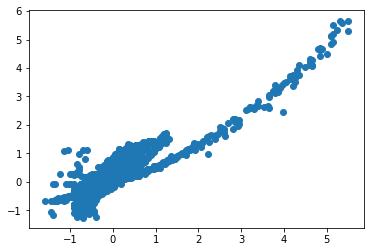

In [123]:
plt.scatter(opt_changes, naive_changes)

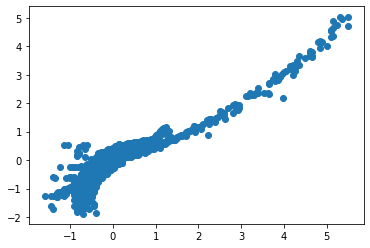

In [124]:
plt.scatter(opt_changes, div_changes)

In [125]:
r_value

0.9490442423359299

In [126]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(opt_changes, naive_changes)

In [127]:
r_value

0.9067710091058737

In [128]:
slope

0.8209177204909764

In [129]:
intercept

0.1684281085264719

In [130]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(opt_changes, naive_changes)

In [131]:
print(slope, intercept, r_value, p_value, std_err)

0.8209177204909764 0.1684281085264719 0.9067710091058737 0.0 0.005968498812148749


In [133]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(div_changes,opt_changes)
print(slope, intercept, r_value, p_value, std_err)

1.1260829468879678 0.02347351816062586 0.9490442423359299 0.0 0.005846954973847527


In [134]:
opt_changes, naive_changes, div_changes = deltas('HON')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data Loaded
-0.07000000000000739 -0.24 -0.34452 0.024116400000002546 -0.15400043999999746
-0.07000000000000739 0.0 -0.003611 0.0002527700000000267 -0.0016141169999999733
-0.07000000000000739 0.0 -0.019214 0.0013449800000001418 -0.008588657999999857
-0.07000000000000739 0.0 -0.025907999999999997 0.0018135600000001913 -0.011580875999999808
-0.07000000000000739 -0.08999999999999997 -0.166271 0.011638970000001228 -0.07432313699999878
-0.07000000000000739 -0.25 -0.42884799999999995 0.030019360000003166 -0.1916950559999968
-0.07000000000000739 -0.39999999999999947 -0.8050189999999999 0.056351330000005945 -0.359843492999994
-0.07000000000000739 0.0 -0.001166 8.162000000000861e-05 -0.0005212019999999913
-0.07000000000000739 -0.03 -0.04506 0.0031542000000003333 -0.020141819999999668
-0.07000000000000739 -0.03 -0.06568099999999999 0.004597670000000485 -0.02935940699999951
-0.07000000000000739 -0.02999999999999997 -0.10026399999999999 0.00701848000000074 -0.04481800799999926
-0.07000000000000739 

-1.5300000000000011 -0.22999999999999998 -0.122833 0.18793449000000015 0.11484885500000014
-1.5300000000000011 -0.25 -0.22161799999999998 0.33907554000000023 0.20721283000000024
-1.5300000000000011 -0.20000000000000018 -0.254945 0.39006585000000027 0.23837357500000028
-1.5300000000000011 -0.1999999999999993 -0.293037 0.4483466100000003 0.2739895950000003
-1.5300000000000011 -0.09999999999999964 -0.334262 0.5114208600000004 0.3125349700000004
-1.5300000000000011 0.1999999999999993 -0.38910700000000004 0.5953337100000005 0.3638150450000005
-1.5300000000000011 -0.20000000000000107 -0.46992799999999996 0.7189898400000004 0.4393826800000005
-1.5300000000000011 -0.15000000000000036 -0.555188 0.8494376400000007 0.5191007800000007
-1.5300000000000011 -0.08000000000000007 -0.02802 0.04287060000000003 0.026198700000000033
-1.5300000000000011 0.010000000000000009 -0.06775700000000001 0.1036682100000001 0.06335279500000009
-1.5300000000000011 -0.06000000000000005 -0.09100599999999999 0.13923918000

0.3300000000000125 -0.039999999999999994 -0.013122 -0.004330260000000164 -0.013056390000000164
0.3300000000000125 -0.05 -0.029532 -0.00974556000000037 -0.02938434000000037
0.3300000000000125 -0.07 -0.069392 -0.022899360000000868 -0.06904504000000086
0.3300000000000125 -0.16000000000000003 -0.206902 -0.06827766000000259 -0.2058674900000026
0.3300000000000125 -0.51 -0.568666 -0.1876597800000071 -0.5658226700000072
0.3300000000000125 0.050000000000000044 -0.029324 -0.009676920000000366 -0.029177380000000367
0.3300000000000125 0.19 -0.034133 -0.011263890000000425 -0.033962335000000426
0.3300000000000125 0.16999999999999993 -0.127059 -0.04192947000000159 -0.1264237050000016
0.3300000000000125 -0.08999999999999986 -0.290114 -0.09573762000000362 -0.2886634300000036
0.3300000000000125 -0.30000000000000027 -0.5279020000000001 -0.17420766000000662 -0.5252624900000067
0.3300000000000125 -0.019999999999999962 -0.024853 -0.008201490000000311 -0.02472873500000031
0.3300000000000125 -0.02000000000000

0.5099999999999909 -1.2000000000000002 -0.810865 -0.4135411499999926 -1.0176355749999926
0.5099999999999909 -1.3199999999999998 -0.8987350000000001 -0.4583548499999919 -1.127912424999992
0.5099999999999909 -1.3599999999999999 -0.934319 -0.4765026899999915 -1.1725703449999916
0.5099999999999909 -0.04 -0.035723000000000005 -0.018218729999999676 -0.04483236499999969
0.5099999999999909 -0.15000000000000002 -0.11391199999999999 -0.05809511999999896 -0.14295955999999896
0.5099999999999909 -0.22999999999999998 -0.172148 -0.08779547999999843 -0.21604573999999846
0.5099999999999909 -0.36 -0.264973 -0.1351362299999976 -0.3325411149999976
0.5099999999999909 -0.55 -0.393335 -0.20060084999999642 -0.49363542499999646
0.5099999999999909 -0.81 -0.548588 -0.279779879999995 -0.6884779399999951
0.5099999999999909 -1.06 -0.7016479999999999 -0.3578404799999936 -0.8805682399999936
0.5099999999999909 -1.1700000000000002 -0.8208610000000001 -0.41863910999999254 -1.0301805549999927
0.5099999999999909 -1.33 -0.

-0.7400000000000091 -0.08999999999999986 -0.435539 0.32229886000000396 -0.002177694999996037
-0.7400000000000091 -0.050000000000000266 -0.5877829999999999 0.4349594200000053 -0.0029389149999946513
-0.7400000000000091 -0.04999999999999982 -0.760066 0.5624488400000069 -0.003800329999993084
-0.7400000000000091 0.04999999999999982 -0.975549 0.7219062600000089 -0.004877744999991123
-0.7400000000000091 0.040000000000000036 -0.096835 0.07165790000000088 -0.00048417499999911886
-0.7400000000000091 0.009999999999999898 -0.172714 0.12780836000000156 -0.0008635699999984285
-0.7400000000000091 0.029999999999999805 -0.18490299999999998 0.13682822000000167 -0.0009245149999983174
-0.7400000000000091 -0.030000000000000027 -0.288486 0.21347964000000264 -0.0014424299999973751
-0.7400000000000091 0.2400000000000002 -0.43547600000000003 0.32225224000000396 -0.0021773799999960375
-0.7400000000000091 -0.03999999999999998 -0.058197000000000006 0.04306578000000053 -0.0002909849999994705
-0.7400000000000091 0.

0.9200199999999938 0.0 -0.005257 -0.004836545139999968 -0.008753010139999969
0.9200199999999938 -0.05 -0.009040000000000001 -0.008316980799999945 -0.015051780799999947
0.9200199999999938 -0.24 -0.15740099999999999 -0.14481206801999902 -0.26207581301999905
0.9200199999999938 -0.4600000000000001 -0.300643 -0.27659757285999814 -0.5005766078599981
0.9200199999999938 -0.7899999999999998 -0.488443 -0.449377328859997 -0.8132673638599971
0.9200199999999938 -1.5699999999999998 -0.70463 -0.6482736925999957 -1.1732230425999957
0.9200199999999938 -1.2000000000000002 -0.668169 -0.6147288433799959 -1.112514748379996
0.9200199999999938 -0.19999999999999996 -0.129471 -0.11911590941999921 -0.2155718044199992
0.9200199999999938 -0.64 -0.289142 -0.2660164228399982 -0.4814272128399983
0.9200199999999938 -0.55 -0.336737 -0.30980477473999796 -0.560673839739998
0.9200199999999938 -0.07 -0.008475 -0.007797169499999947 -0.014111044499999949
0.9200199999999938 -0.009999999999999995 -0.011044 -0.0101607008799999

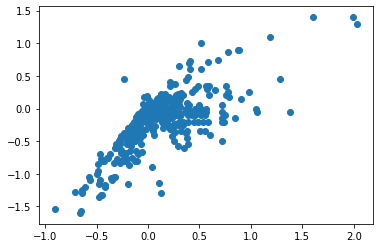

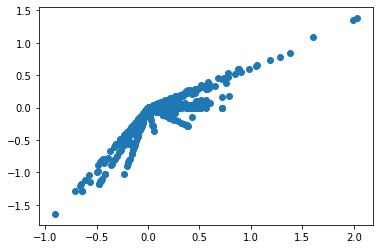

NAIVE METHOD slope: 0.8243608111998421 	 intercept: -0.21326788722658868	 r_value: 0.6877555476309231 	 p_value 5.589840097505662e-78: 	std_err: 0.03723823188313495
DIV METHOD slope: 0.9118514705644019 	 intercept: -0.04652593408894384	 r_value: 0.840076942849492 	 p_value 3.770901718111909e-147: 	std_err: 0.025198938687853285


In [138]:
analyze(opt_changes, naive_changes, div_changes)

In [139]:
opt_changes, naive_changes, div_changes = deltas('JNJ')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data Loaded
-3.230000000000004 0.54 -0.090692 0.29293516000000036 0.22491616000000034
-3.230000000000004 0.6599999999999999 -0.109088 0.35235424000000043 0.27053824000000043
-3.230000000000004 0.77 -0.135461 0.43753903000000055 0.3359432800000005
-3.230000000000004 0.9299999999999999 -0.16633900000000001 0.5372749700000007 0.4125207200000007
-3.230000000000004 1.0899999999999999 -0.21044699999999997 0.6797438100000007 0.5219085600000007
-3.230000000000004 1.29 -0.26121300000000003 0.8437179900000011 0.6478082400000011
-3.230000000000004 1.4899999999999998 -0.324198 1.0471595400000013 0.8040110400000012
-3.230000000000004 1.69 -0.398982 1.2887118600000016 0.9894753600000016
-3.230000000000004 1.85 -0.484059 1.563510570000002 1.2004663200000019
-3.230000000000004 2.02 -0.576064 1.8606867200000023 1.4286387200000024
-3.230000000000004 2.1900000000000004 -0.6729229999999999 2.1735412900000024 1.6688490400000024
-3.230000000000004 2.32 -0.76936 2.485032800000003 1.9080128000000032
-3.230000

-0.009999999999990905 -0.7999999999999998 -0.742185 0.00742184999999325 -0.5492169000000068
-0.009999999999990905 -0.20999999999999996 -0.249995 0.002499949999997726 -0.18499630000000228
-0.009999999999990905 -0.27 -0.280434 0.0028043399999974497 -0.20752116000000256
-0.009999999999990905 -0.3800000000000001 -0.427422 0.004274219999996113 -0.3162922800000039
-0.009999999999990905 0.09999999999999998 -0.127762 0.0012776199999988379 -0.09454388000000115
-0.009999999999990905 -0.32000000000000006 -0.375463 0.003754629999996585 -0.2778426200000034
-0.009999999999990905 -0.5499999999999998 -0.698155 0.00698154999999365 -0.5166347000000063
-0.009999999999990905 -0.8499999999999996 -0.879316 0.008793159999992002 -0.650693840000008
-0.009999999999990905 -0.03 -0.041718 0.00041717999999962054 -0.03087132000000038
-0.009999999999990905 -0.06 -0.05744 0.0005743999999994776 -0.04250560000000052
-0.009999999999990905 -0.06 -0.080636 0.0008063599999992666 -0.05967064000000073
-0.009999999999990905 -

-0.0799999999999983 -1.450000000000001 -0.861964 0.06895711999999853 -0.5775158800000014
-0.0799999999999983 -0.04000000000000001 -0.007443000000000001 0.0005954399999999873 -0.004986810000000013
-0.0799999999999983 -0.06 -0.009549 0.0007639199999999837 -0.006397830000000017
-0.0799999999999983 -0.07 -0.049263 0.003941039999999916 -0.033006210000000084
-0.0799999999999983 -0.020000000000000018 -0.059645000000000004 0.0047715999999998985 -0.039962150000000106
-0.0799999999999983 -0.06 -0.079886 0.006390879999999864 -0.05352362000000013
-0.0799999999999983 -0.07000000000000006 -0.10645999999999999 0.008516799999999818 -0.07132820000000017
-0.0799999999999983 -0.08000000000000007 -0.15029700000000001 0.012023759999999745 -0.10069899000000027
-0.0799999999999983 -0.08000000000000007 -0.21286100000000002 0.01702887999999964 -0.14261687000000037
-0.0799999999999983 -0.17999999999999972 -0.352624 0.0282099199999994 -0.2362580800000006
-0.0799999999999983 -0.35000000000000053 -0.581544 0.04652

-0.20999999999999375 0.039999999999999994 -0.0062640000000000005 0.001315439999999961 -0.0036957600000000397
-0.20999999999999375 -0.08999999999999997 -0.032633999999999996 0.006853139999999795 -0.019254060000000205
-0.20999999999999375 -0.09999999999999998 -0.044489999999999995 0.00934289999999972 -0.02624910000000028
-0.20999999999999375 -0.13 -0.060779999999999994 0.012763799999999619 -0.035860200000000376
-0.20999999999999375 -0.10999999999999999 -0.070026 0.014705459999999563 -0.04131534000000044
-0.20999999999999375 -0.08999999999999997 -0.080981 0.017006009999999492 -0.04777879000000051
-0.20999999999999375 -0.10999999999999988 -0.09535 0.020023499999999406 -0.056256500000000605
-0.20999999999999375 -0.10000000000000009 -0.11137799999999999 0.0233893799999993 -0.06571302000000069
-0.20999999999999375 -0.1200000000000001 -0.13131800000000002 0.027576779999999183 -0.07747762000000084
-0.20999999999999375 -0.1100000000000001 -0.155692 0.03269531999999903 -0.09185828000000097
-0.799

-0.7999999999999972 0.0 -0.089974 0.07197919999999974 -2.5971713668582197e-16
-1.2099999999999937 0.0 -0.022616 0.02736535999999986 0.009272559999999859
-1.2099999999999937 -0.07 -0.041805 0.05058404999999974 0.017140049999999737
-1.2099999999999937 -0.06 -0.114881 0.1390060099999993 0.047101209999999276
-1.2099999999999937 -0.06 -0.199532 0.24143371999999874 0.08180811999999874
-1.2099999999999937 -0.08000000000000002 -0.34770300000000004 0.4207206299999979 0.14255822999999782
-1.2099999999999937 -0.030000000000000027 -0.534076 0.6462319599999966 0.21897115999999664
-1.2099999999999937 0.07000000000000006 -0.692617 0.8380665699999957 0.28397296999999566
-1.2099999999999937 -0.43000000000000016 -0.780736 0.9446905599999951 0.3201017599999951
-1.2099999999999937 -0.6499999999999995 -0.859426 1.0399054599999946 0.3523646599999946
-1.2099999999999937 0.010000000000000002 -0.006497 0.00786136999999996 0.002663769999999959
-1.2099999999999937 -0.08 -0.021363999999999998 0.025850439999999864

1.0300000000000011 -0.18000000000000002 -0.230767 -0.23769001000000026 -0.4223036100000003
1.0300000000000011 -0.33 -0.352876 -0.3634622800000004 -0.6457630800000005
1.0300000000000011 0.0 -0.007606999999999999 -0.007835210000000007 -0.013920810000000007
1.0300000000000011 -0.05 -0.015269 -0.015727070000000017 -0.027942270000000016
1.0300000000000011 0.0 -0.020838 -0.021463140000000023 -0.03813354000000002
1.0300000000000011 -0.039999999999999994 -0.035406 -0.03646818000000004 -0.06479298000000004
1.0300000000000011 -0.009999999999999995 -0.046631 -0.048029930000000054 -0.08533473000000005
1.0300000000000011 -0.020000000000000018 -0.065598 -0.06756594000000007 -0.12004434000000008
1.0300000000000011 -0.04000000000000001 -0.09072100000000001 -0.09344263000000011 -0.16601943000000013
1.0300000000000011 -0.08000000000000002 -0.12971300000000002 -0.13360439000000018 -0.2373747900000002
1.0300000000000011 -0.14 -0.18850799999999998 -0.19416324000000018 -0.3449696400000002
1.0300000000000011

0.01999999999999602 -0.5 -0.624057 -0.012481139999997516 -0.5366890199999975
0.01999999999999602 -0.83 -0.9135459999999999 -0.018270919999996364 -0.7856495599999962
0.01999999999999602 -0.020000000000000004 -0.025065999999999998 -0.0005013199999999002 -0.021556759999999897
0.01999999999999602 -0.03 -0.029744999999999997 -0.0005948999999998816 -0.02558069999999988
0.01999999999999602 -0.04000000000000001 -0.037637000000000004 -0.0007527399999998503 -0.03236781999999985
0.01999999999999602 -0.04 -0.047163 -0.0009432599999998122 -0.04056017999999981
0.01999999999999602 -0.06 -0.08280900000000001 -0.0016561799999996706 -0.07121573999999968
0.01999999999999602 -0.07999999999999999 -0.1221 -0.002441999999999514 -0.10500599999999952
0.01999999999999602 -0.14 -0.210017 -0.004200339999999164 -0.18061461999999917
0.01999999999999602 -0.26 -0.358319 -0.007166379999998574 -0.3081543399999986
0.01999999999999602 -0.44999999999999996 -0.5576399999999999 -0.011152799999997779 -0.4795703999999977
0.01

-1.2100099999999827 0.3000000000000007 -0.9688049999999999 1.1722637380499832 0.35846753804998327
-1.2100099999999827 0.45000000000000107 -0.973899 1.178427528989983 0.3603523689899832
-1.2100099999999827 0.29999999999999716 -0.978554 1.1840601255399832 0.36207476553998313
-1.2100099999999827 0.25 -0.97919 1.184829691899983 0.3623100918999831
-1.2100099999999827 0.25 -0.975571 1.1804506657099831 0.36097102570998313
-1.2100099999999827 0.009999999999999995 -0.011949 0.014458409489999793 0.004421249489999794
-1.2100099999999827 -0.04000000000000001 -0.073029 0.08836582028999873 0.027021460289998737
-1.2100099999999827 -0.05999999999999997 -0.11425899999999999 0.138254532589998 0.042276972589998026
-1.2100099999999827 -0.08999999999999997 -0.27193 0.3290380192999953 0.1006168192999953
-1.2100099999999827 -0.07999999999999996 -0.36601 0.4428757600999937 0.13542736009999368
-1.2100099999999827 -0.040000000000000036 -0.479547 0.5802566654699917 0.17743718546999174
-1.2100099999999827 0.04999

-1.2100099999999827 0.010000000000000009 -0.014472 0.01751126471999975 0.00535478471999975
-1.2100099999999827 0.0 -0.01948 0.023570994799999665 0.007207794799999664
-1.2100099999999827 0.0 -0.025333 0.030653183329999563 0.009373463329999563
-1.2100099999999827 0.0 -0.042256 0.05113018255999927 0.01563514255999927
-1.2100099999999827 0.0 -0.054462 0.06589956461999906 0.02015148461999906
-0.7800000000000011 0.0 -0.010843 0.008457540000000012 -0.0013011599999999878
-0.7800000000000011 0.0 -0.034151999999999995 0.026638560000000033 -0.004098239999999961
-0.7800000000000011 -0.03 -0.053617 0.04182126000000006 -0.00643403999999994
-0.7800000000000011 -0.06 -0.12427200000000001 0.09693216000000014 -0.014912639999999863
-0.7800000000000011 -0.07999999999999999 -0.190322 0.14845116000000022 -0.022838639999999785
-0.7800000000000011 -0.10999999999999999 -0.293249 0.22873422000000032 -0.035189879999999674
-0.7800000000000011 -0.15000000000000002 -0.43198800000000004 0.3369506400000005 -0.0518385

-0.7800000000000011 -0.06000000000000005 -0.406068 0.31673304000000047 -0.04872815999999955
-0.7800000000000011 -0.10000000000000053 -0.625713 0.4880561400000007 -0.0750855599999993
-0.7800000000000011 -0.1999999999999993 -0.8323 0.6491940000000009 -0.09987599999999908
-0.7800000000000011 -0.09999999999999964 -0.97604 0.7613112000000011 -0.11712479999999892
-0.7800000000000011 -0.020000000000000018 -0.161442 0.1259247600000002 -0.01937303999999982
-0.7800000000000011 -0.040000000000000036 -0.265415 0.2070237000000003 -0.031849799999999706
-0.7800000000000011 -0.10000000000000009 -0.411867 0.32125626000000046 -0.04942403999999954
-0.7800000000000011 -0.15000000000000036 -0.581978 0.4539428400000007 -0.06983735999999935
-0.7800000000000011 0.0 -0.7404149999999999 0.5775237000000008 -0.08884979999999916
-0.7800000000000011 -0.09999999999999964 -0.8553719999999999 0.6671901600000009 -0.10264463999999904
-0.7800000000000011 -0.10000000000000142 -0.930858 0.7260692400000011 -0.11170295999999

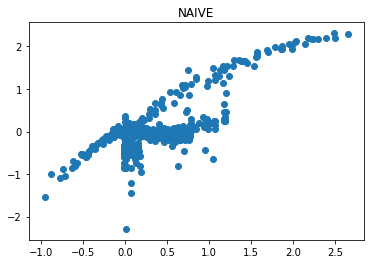

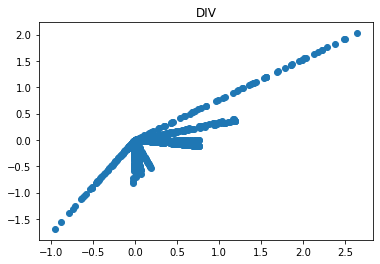

NAIVE METHOD slope: 0.8586117923689595 	 intercept: -0.182709726879388	 r_value: 0.7867922306594551 	 p_value 2.0679508515597066e-182: 	std_err: 0.022968154530232664
DIV METHOD slope: 1.1669657519536931 	 intercept: 0.03617013323219506	 r_value: 0.9129685681720251 	 p_value 0.0: 	std_err: 0.017784638442498994


In [141]:
analyze(opt_changes, naive_changes, div_changes)

In [143]:
opt_changes, naive_changes, div_changes = deltas('PRU')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data Loaded
-4.1200000000000045 0.62 -0.09178 0.3781336000000004 0.3249012000000004
-4.1200000000000045 0.9400000000000001 -0.14866300000000002 0.6124915600000007 0.5262670200000007
-4.1200000000000045 1.39 -0.239983 0.9887299600000011 0.8495398200000011
-4.1200000000000045 1.9700000000000002 -0.368153 1.5167903600000017 1.3032616200000018
-4.1200000000000045 2.53 -0.527267 2.1723400400000026 1.8665251800000024
-4.1200000000000045 2.95 -0.690882 2.846433840000003 2.445722280000003
-4.1200000000000045 1.12 -0.21434 0.883080800000001 0.758763600000001
-4.1200000000000045 1.4100000000000001 -0.273409 1.1264450800000012 0.9678678600000012
-4.1200000000000045 1.7000000000000002 -0.34227199999999997 1.4101606400000015 1.2116428800000014
-4.1200000000000045 2.05 -0.421738 1.737560560000002 1.492952520000002
-4.1200000000000045 2.3 -0.506125 2.0852350000000026 1.7916825000000025
-4.1200000000000045 1.1399999999999997 -0.22647399999999998 0.933072880000001 0.801717960000001
-4.1200000000000045 

-0.3399999999999892 -0.20000000000000018 -0.45186000000000004 0.15363239999999515 -0.16266960000000488
-0.3399999999999892 -0.010000000000000009 -0.08358099999999999 0.028417539999999093 -0.030089160000000895
-0.3399999999999892 0.019999999999999796 -0.104094 0.035391959999998876 -0.03747384000000112
-0.3399999999999892 -0.07000000000000006 -0.128659 0.04374405999999861 -0.04631724000000138
-0.3399999999999892 -0.09000000000000008 -0.162461 0.055236739999998244 -0.058485960000001745
-0.3399999999999892 -0.06000000000000005 -0.199523 0.06783781999999784 -0.07182828000000215
-0.3399999999999892 -0.08000000000000007 -0.248209 0.08439105999999733 -0.08935524000000268
-0.3399999999999892 -0.20000000000000018 -0.306758 0.10429771999999668 -0.11043288000000329
-0.3399999999999892 -0.10000000000000009 -0.373316 0.12692743999999595 -0.134393760000004
-0.3399999999999892 -0.14999999999999947 -0.447978 0.15231251999999515 -0.1612720800000048
-0.009999999999990905 -0.6499999999999999 -0.5649 0.005

-0.7099999999999937 0.0 -0.12071199999999999 0.08570551999999923 -0.004828480000000754
-0.7099999999999937 -0.020000000000000018 -0.18578499999999998 0.1319073499999988 -0.007431400000001161
-0.7099999999999937 -0.020000000000000018 -0.286457 0.2033844699999982 -0.011458280000001791
-0.7099999999999937 0.0 -0.350891 0.2491326099999978 -0.014035640000002195
-0.7099999999999937 -0.05000000000000071 -0.421572 0.29931611999999735 -0.016862880000002637
-0.7099999999999937 0.07999999999999999 -0.004307 0.0030579699999999732 -0.00017228000000002694
-0.7099999999999937 0.26 -0.007858 0.005579179999999951 -0.00031432000000004915
-0.7099999999999937 0.0 -0.009481 0.006731509999999941 -0.0003792400000000593
-0.7099999999999937 -0.07000000000000006 -0.060695000000000006 0.043093449999999624 -0.00242780000000038
-0.7099999999999937 0.020000000000000018 -0.07059 0.05011889999999956 -0.0028236000000004414
-0.7099999999999937 -0.040000000000000036 -0.085279 0.060548089999999465 -0.003411160000000533
-

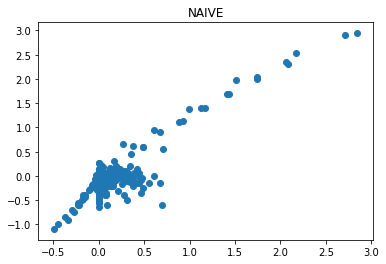

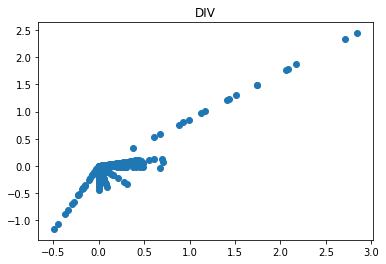

NAIVE METHOD slope: 1.1785329352797955 	 intercept: -0.21331432618687038	 r_value: 0.9121084613164725 	 p_value 4.257337809768139e-89: 	std_err: 0.03531293179898097
DIV METHOD slope: 1.2825832304713907 	 intercept: 0.014106529592379013	 r_value: 0.969159614060133 	 p_value 7.437531619926356e-139: 	std_err: 0.02174199302657428


In [144]:
analyze(opt_changes, naive_changes, div_changes)

In [148]:
opt_changes, naive_changes, div_changes = deltas('WLK')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data Loaded
-0.12999999999999545 -0.15000000000000036 -0.378946 0.04926297999999828 -0.01970519200000172
-0.12999999999999545 -0.050000000000000044 -0.153356 0.019936279999999303 -0.007974512000000697
-0.12999999999999545 -0.10000000000000009 -0.26336 0.0342367999999988 -0.013694720000001196
-1.8100000000000023 0.0 -0.048746 0.0882302600000001 0.07935848800000012
-1.8100000000000023 -0.04999999999999993 -0.092701 0.16778881000000023 0.15091722800000024
-1.8100000000000023 0.0 -0.13989300000000002 0.25320633000000037 0.22774580400000036
1.3999999999999986 -0.45000000000000007 -0.339023 -0.47463219999999956 -0.5363343859999995
1.3999999999999986 -0.55 -0.366931 -0.5137033999999995 -0.5804848419999995
1.3999999999999986 -2.0 -0.624116 -0.8737623999999992 -0.987351511999999
1.3999999999999986 -0.8999999999999995 -0.556365 -0.7789109999999992 -0.8801694299999991
1.3999999999999986 -2.0 -0.735632 -1.029884799999999 -1.1637698239999987
1.3999999999999986 -0.5 -0.383694 -0.5371715999999994 -0.

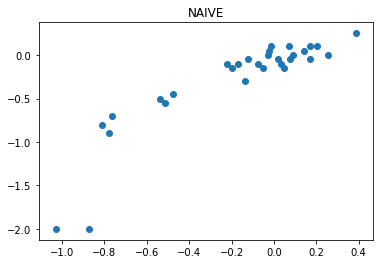

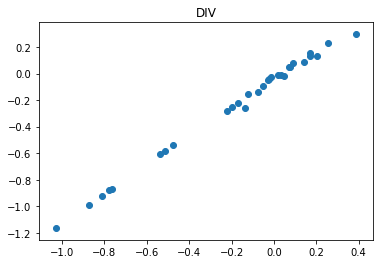

NAIVE METHOD slope: 1.285961350438519 	 intercept: -0.06275462475190136	 r_value: 0.8860768592757701 	 p_value 7.473606475907554e-11: 	std_err: 0.1271344280929857
DIV METHOD slope: 1.2158599214857588 	 intercept: -0.003208025892910027	 r_value: 0.893477920244567 	 p_value 3.059214673559592e-11: 	std_err: 0.11549698408226972


In [149]:
analyze(opt_changes, naive_changes, div_changes)

In [ ]:
#price of an option